In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from matplotlib.colors import LinearSegmentedColormap
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

pd.set_option("display.max_columns", None)

In [181]:
random_state = 123
sns.set()
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 98

colors = ['#646E78','#d1d646', '#97bf78', '#7ca282', '#61858c', '#466796', '#8967b5', '#b363b9', '#d560bc', '#f25dbf']

show_plots = True
save_plots = False
img_counter = 0
kaggle = False
div_colors = ['#466796','#9ca9c3','#f1f1f1','#e5e39f','#d1d646']
div_cmap = LinearSegmentedColormap.from_list("mycmap", div_colors)


def log_transform_data(df, col):
    return np.log1p(df[col])

## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), constrained_layout=True, sharey=True)
        
        for ax, feat in zip(axes.flatten(), features):
            ax.set_title(feat, y=1)
            ax.legend()
            df.pivot(columns='Buy')[feat].plot(kind = 'hist', stacked=True, ax=ax, color=colors[0:2])
    
        if (len(axes.flatten())) > len(features):
            for f in range(len(axes.flatten())-len(features)):
                axes.flatten()[(f+1)*-1].axis('off')
        plt.suptitle(title)
        plt.show()
    else:
        print("show_plots is currently set to False")

## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig = plt.figure(figsize=(11, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns='IsCanceled')[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=colors[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==0,feat], ax=axs[1], color=colors[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==1,feat], ax=axs[2], color=colors[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def make_corr_heatmap(d_X, d_y, method, title="Triangle Correlation Heatmap"):
    if show_plots:
        fig, ax = plt.subplots(figsize=(13, 7))
    
        map_corr = np.round(d_X.join(d_y).corr(method=method),decimals=2)
    
        mask_annot = np.absolute(map_corr.values) >= 0.65
        annot = np.where(mask_annot, map_corr.values, np.full(map_corr.shape,"")) # Try to understand what this np.where() does
        mask = np.triu(np.ones_like(map_corr, dtype=bool))
    
        heatmap = sns.heatmap(map_corr, mask=mask, vmin=-1, vmax=1, annot=annot, cmap=div_cmap, fmt='')
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def save_fig(title, fig, dest='img/', img_counter=img_counter):
    img_counter = img_counter + 1
    fn = dest + str(img_counter) + '_' + title.replace(' ','-') + '.png'
    fig.savefig(fn, bbox_inches='tight')
    
def plot_cat_counts(df, features, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,'IsCanceled']).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=colors)

            df2 = df.groupby([feat,'IsCanceled']).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=colors)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

In [182]:
# data_train_num = data_train.select_dtypes(include=np.number).set_index(data_train.index)
# data_train_cat = data_train.select_dtypes(exclude=np.number).set_index(data_train.index).drop("Buy", axis = 1)
# num_feat = data_train_num.columns.tolist()
# cat_feat = data_train_cat.columns.tolist()

# data_test_num = data_test.select_dtypes(include=np.number).set_index(data_test.index)
# data_test_cat = data_test.select_dtypes(exclude=np.number).set_index(data_test.index)

In [183]:
# original_cat_feats = data_train.select_dtypes(exclude=np.number).columns.tolist()

# plot_cat_counts(data_train, original_cat_feats)

In [184]:
# plot_histograms_boxplots(data_train, num_feat, rows=4)

## IMPORT AND EXPLORATION

In [185]:
data = pd.read_csv("H2.csv")
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [187]:
# Feature Engineering
data["DurationOfStay"] = data["StaysInWeekNights"] + data["StaysInWeekendNights"]
data["TotalValue"] = data["DurationOfStay"] * data["ADR"]
data["ArrivalDateMonthNumber"] = data["ArrivalDateMonth"].apply(lambda x : datetime.datetime.strptime(x, "%B").month).astype("str")
data["ArrivalDate"] = data["ArrivalDateYear"].astype(str) + "-" + data["ArrivalDateMonthNumber"].astype(str) + "-" + data["ArrivalDateDayOfMonth"].astype(str)
data["ArrivalDate"] = pd.to_datetime(data["ArrivalDate"])
data['ArrivalDayOfWeek'] = data['ArrivalDate'].dt.dayofweek.astype('str')
data.drop("ArrivalDateMonth", inplace = True, axis = 1)
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3


In [188]:
# Feature Engineering
data["ReservationStatusDate"] = pd.to_datetime(data["ReservationStatusDate"])

data['ReservationDayOfMonth'] = data['ReservationStatusDate'].dt.day.astype('str')
data['ReservationWeekOfYear'] = data['ReservationStatusDate'].dt.weekofyear.astype('str')
data['ReservationMonth'] = data['ReservationStatusDate'].dt.month.astype('str')
data['ReservationDayOfWeek'] = data['ReservationStatusDate'].dt.dayofweek.astype('str')

data["IsRoomChanged"] = (data["AssignedRoomType"] != data["ReservedRoomType"])

In [189]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2,3,27,7,4,False
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2,1,27,7,2,False
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2,30,18,4,3,False
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2,23,26,6,1,False
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3,2,14,4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2,6,36,9,2,False
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3,7,36,9,3,False
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3,7,36,9,3,False
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3,7,36,9,3,False


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IsCanceled                   79330 non-null  int64         
 1   LeadTime                     79330 non-null  int64         
 2   ArrivalDateYear              79330 non-null  int64         
 3   ArrivalDateWeekNumber        79330 non-null  int64         
 4   ArrivalDateDayOfMonth        79330 non-null  int64         
 5   StaysInWeekendNights         79330 non-null  int64         
 6   StaysInWeekNights            79330 non-null  int64         
 7   Adults                       79330 non-null  int64         
 8   Children                     79326 non-null  float64       
 9   Babies                       79330 non-null  int64         
 10  Meal                         79330 non-null  object        
 11  Country                      79306 non-nu

In [191]:
# saving numeric features into a list
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
data[numeric_features]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue
0,0,6,2015,27,1,0,2,1,0.0,0,0,0,0,0,0,0.00,0,0,2,0.00
1,1,88,2015,27,1,0,4,2,0.0,0,0,0,0,0,0,76.50,0,1,4,306.00
2,1,65,2015,27,1,0,4,1,0.0,0,0,0,0,0,0,68.00,0,1,4,272.00
3,1,92,2015,27,1,2,4,2,0.0,0,0,0,0,0,0,76.50,0,2,6,459.00
4,1,100,2015,27,2,0,2,2,0.0,0,0,0,0,0,0,76.50,0,1,2,153.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0,7,672.98
79326,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2,7,1578.01
79327,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4,7,1103.97
79328,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0,7,730.80


In [192]:
# metric_features is a subset of numeric_features

to_discard = ["ArrivalDateYear", "ArrivalDateDayOfMonth", "IsRepeatedGuest", "IsCanceled"]

metric_features = numeric_features.copy()
for feat in to_discard:
    metric_features.remove(feat)

In [193]:
categorical_features = data.select_dtypes(exclude=np.number).set_index(data.index).columns.tolist()

#adding the numeric non metric features
categorical_features.extend(to_discard)

data[categorical_features]

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged,ArrivalDateYear,ArrivalDateDayOfMonth,IsRepeatedGuest,IsCanceled
0,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,6,NULL,Transient,Check-Out,2015-07-03,7,2015-07-01,2,3,27,7,4,False,2015,1,0,0
1,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-07-01,7,2015-07-01,2,1,27,7,2,False,2015,1,0,1
2,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-30,7,2015-07-01,2,30,18,4,3,False,2015,1,0,1
3,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-06-23,7,2015-07-01,2,23,26,6,1,False,2015,1,0,1
4,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-02,7,2015-07-02,3,2,14,4,3,False,2015,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,394,NULL,Transient,Check-Out,2017-09-06,8,2017-08-30,2,6,36,9,2,False,2017,30,0,0
79326,BB,FRA,Online TA,TA/TO,E,E,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,False,2017,31,0,0
79327,BB,DEU,Online TA,TA/TO,D,D,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,False,2017,31,0,0
79328,BB,GBR,Online TA,TA/TO,A,A,No Deposit,89,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,False,2017,31,0,0


In [194]:
data.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,NaN,NaN,NaN,NaT,NaT,0.41727,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,NaN,NaN,NaN,NaT,NaT,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,NaN,NaN,NaN,NaT,NaT,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,NaN,NaN,NaN,NaT,NaT,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,NaN,NaN,NaN,NaT,NaT,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,NaN,NaN,NaN,NaT,NaT,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,NaN,NaN,NaN,NaT,NaT,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,NaN,NaN,NaN,NaT,NaT,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,NaN,NaN,NaN,NaT,NaT,0.09137,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,NaN,NaN,NaN,NaT,NaT,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


In [195]:
"Percentage of suspect duplicated data: " , (data.duplicated().sum() / len(data)) * 100

('Percentage of suspect duplicated data: ', 32.65095172066053)

In [196]:
# Let's analyze the duplicates
duplicates = data.loc[data.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
5405,179,1,277,2016,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,100.00,0,0,Canceled,2016-04-04,3,300.00,11,2016-11-07,0,4,14,4,0,False
4180,149,1,68,2016,8,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,37,NULL,0,Transient,75.00,0,0,Canceled,2016-01-06,2,150.00,2,2016-02-17,2,6,1,1,2,False
5073,108,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,6,2016-06-15,2,18,3,1,0,False
4878,100,1,158,2016,22,24,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,31,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,5,2016-05-24,1,18,3,1,0,False
3851,99,1,34,2015,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19,NULL,0,Transient,90.00,0,0,Canceled,2015-11-17,2,180.00,12,2015-12-08,1,17,47,11,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,1,0,59,2017,17,26,0,1,2,0.0,0,BB,CHE,Direct,Direct,0,0,0,D,D,0,No Deposit,14,NULL,0,Transient,130.50,0,2,Check-Out,2017-04-27,1,130.50,4,2017-04-26,2,27,17,4,3,False
1480,1,0,59,2017,14,6,0,3,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,117.00,0,2,Check-Out,2017-04-09,3,351.00,4,2017-04-06,3,9,14,4,6,False
1479,1,0,59,2017,12,23,0,1,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,79.20,0,0,Check-Out,2017-03-24,1,79.20,3,2017-03-23,3,24,12,3,4,False
3383,1,0,409,2017,22,31,0,3,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229,NULL,0,Transient-Party,112.67,0,2,Check-Out,2017-06-03,3,338.01,5,2017-05-31,2,3,22,6,5,False


In [197]:
#Exploring the day with most populated duplicates
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016)
].value_counts("MarketSegment")

Series([], dtype: int64)

In [198]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016) & 
(data.MarketSegment == "Groups")
].value_counts("Agent")

Series([], dtype: int64)

In [199]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016)
].value_counts("MarketSegment")

Series([], dtype: int64)

In [200]:
data.loc[data.duplicated()].sort_values("ArrivalDateDayOfMonth")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
23073,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,False
23105,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,False
23104,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,False
23103,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,False
23102,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36391,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,False
36390,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,False
36389,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,False
36387,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3,False


In [201]:
# Checking NaN values
data.isna().sum(axis = 0).loc[data.isna().sum(axis = 0) > 0]

Children     4
Country     24
dtype: int64

In [202]:
#Cardinalities of children values
data["Children"].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [203]:
# Cardinalities for countries
data["Country"].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [204]:
# Replacing NaN values with the mode 

data["Children"].replace(np.nan, data["Children"].mode()[0], inplace = True) #MODE = 0
data["Country"].replace(np.nan, data["Country"].mode()[0], inplace = True)   #MODE = PRT

data.loc[(data["Children"].isna() == True) | (data["Country"].isna() == True)]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [205]:
data["Children"] = data["Children"].astype("int")

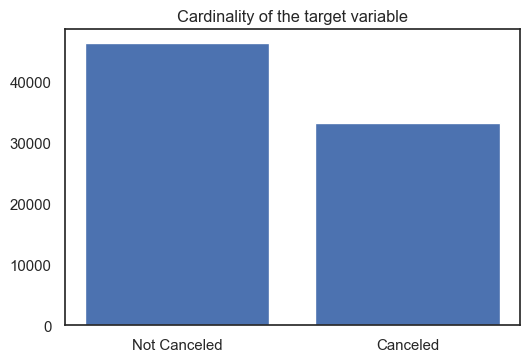

In [206]:
sns.set(style = "white")
plt.bar(height=data["IsCanceled"].value_counts(), x = ["Not Canceled", "Canceled"])
plt.title("Cardinality of the target variable")
plt.show()

In [207]:
def pairwise_relation(data, features = data.select_dtypes(include=np.number).set_index(data.index).columns,
 title = "Pairwise Relationship of Metric Variables", target = "IsCanceled"):
    
    # Pairwise Relationship of Numerical Variables
    sns.set(style='white')

    # Setting pairplot
    sns.pairplot(data[features], diag_kind="hist", hue=target)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title)

    plt.show()

In [208]:
#around 35 minutes or run time

# pairwise_relationship(data)

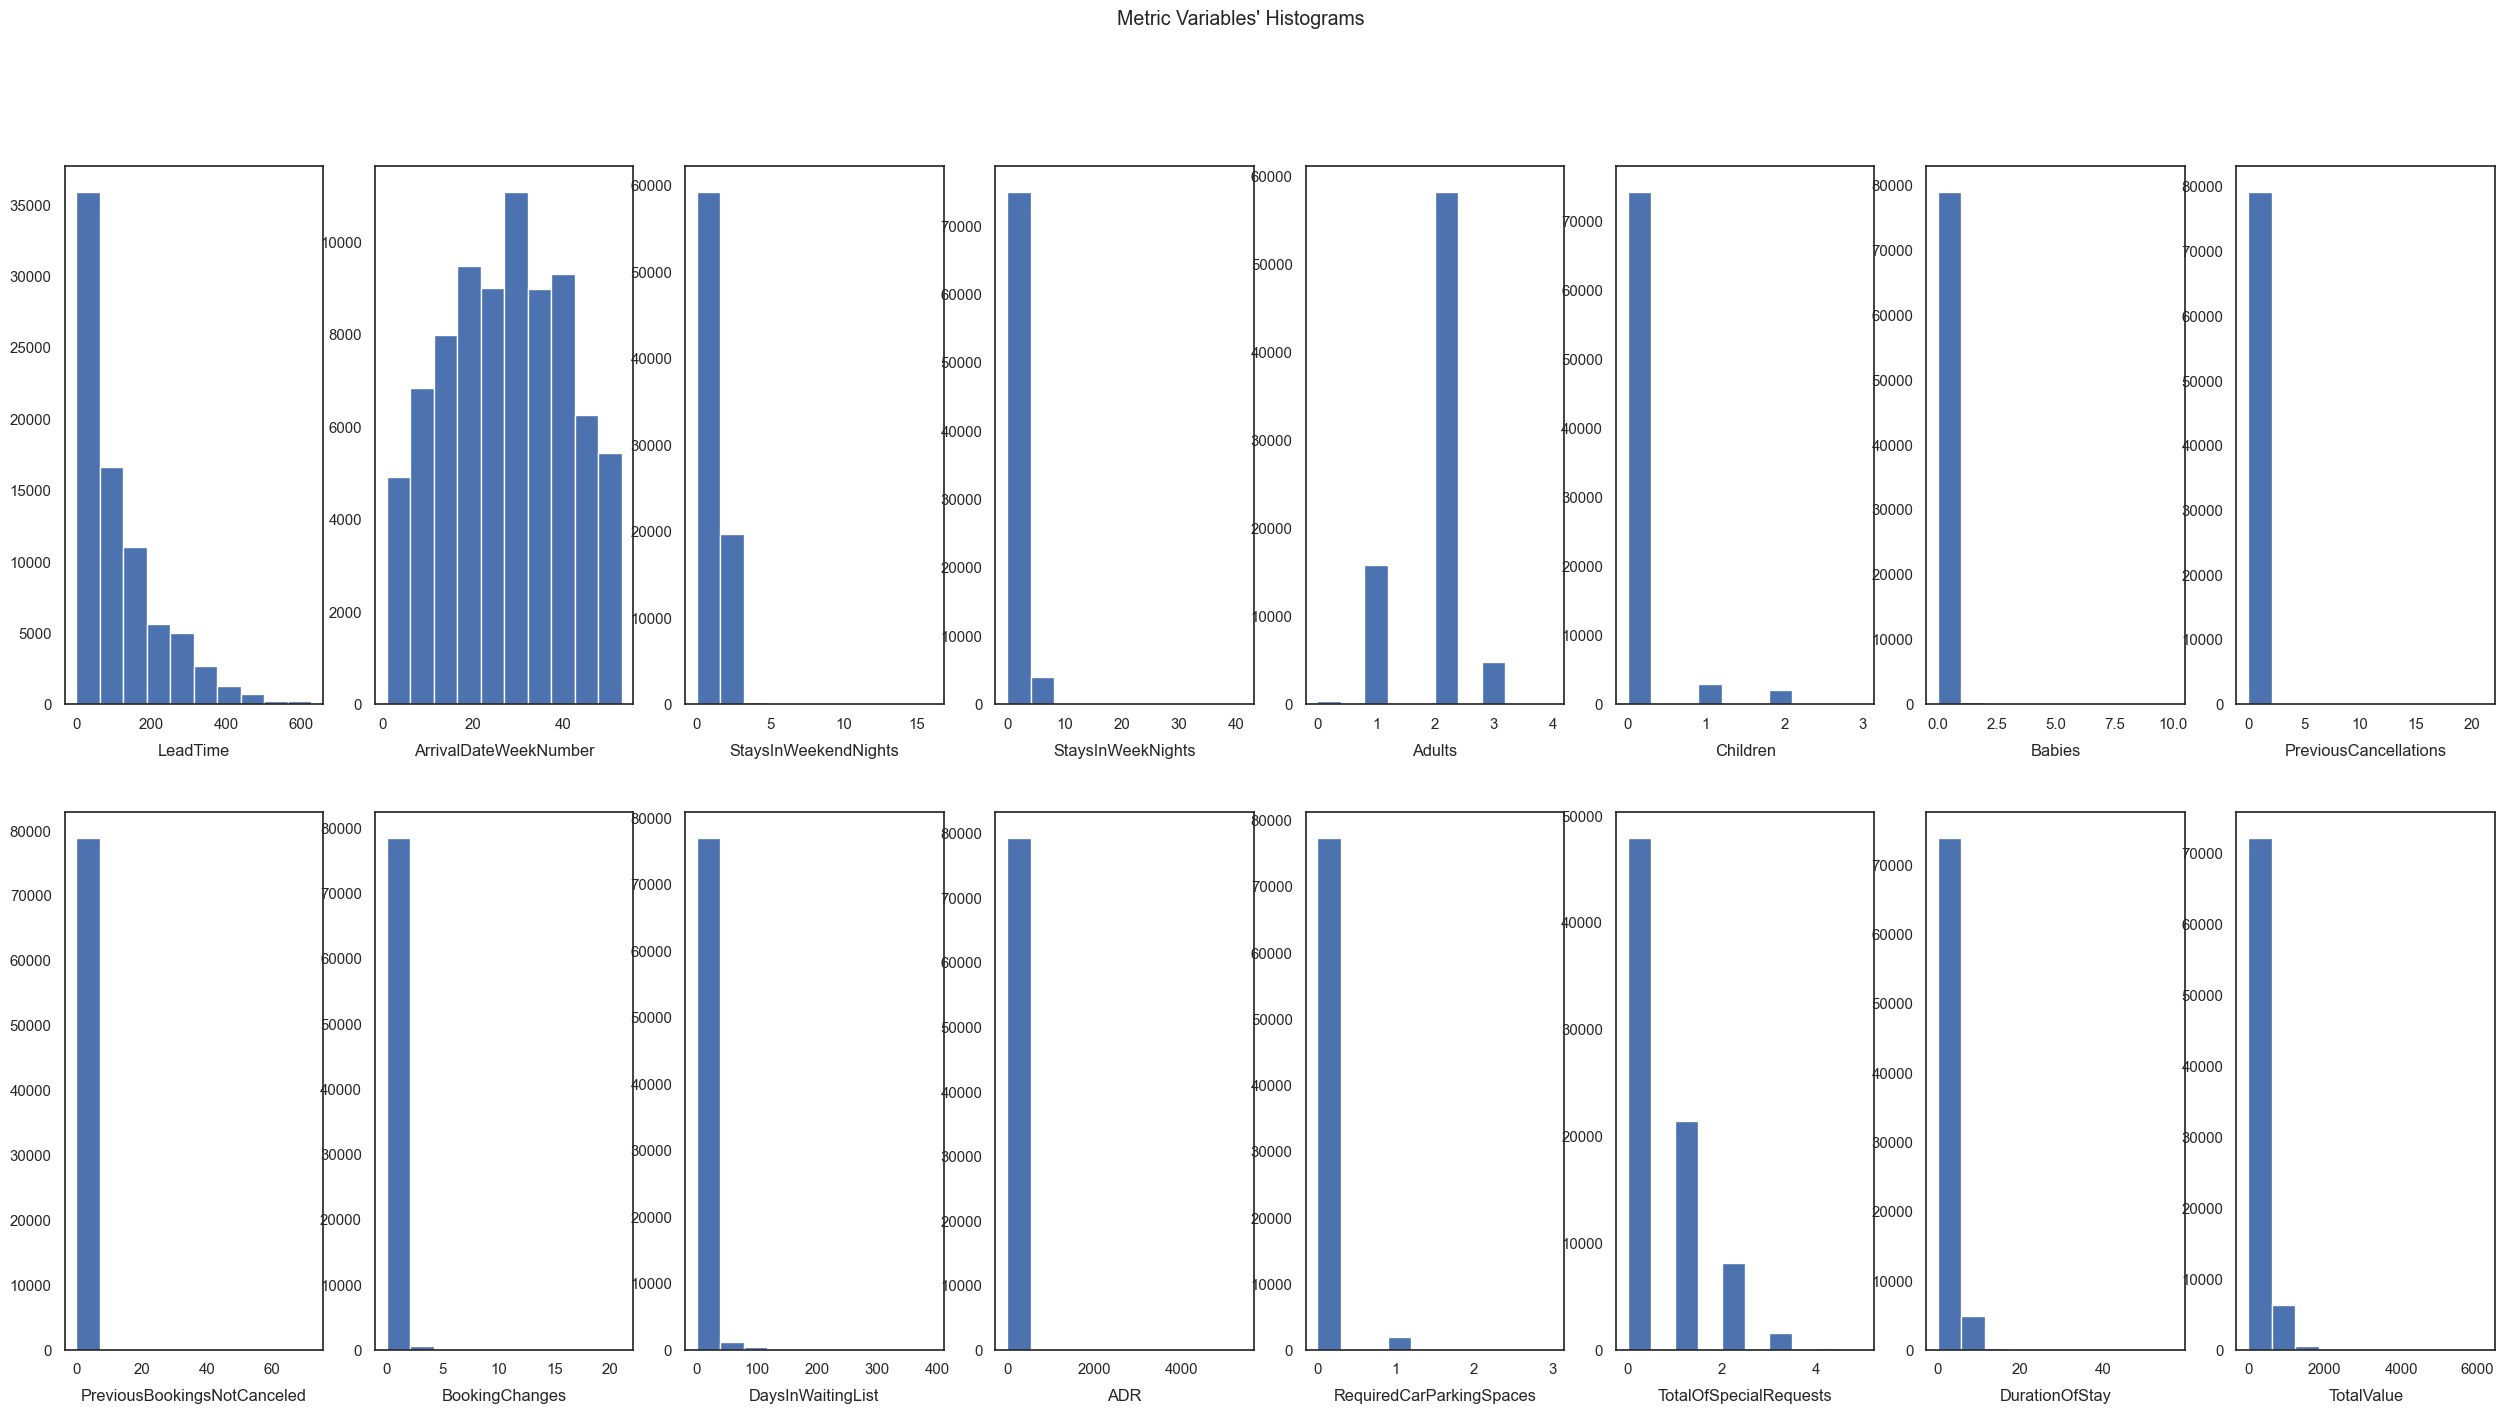

In [209]:
sns.set(style='white')

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(32, 16))

for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.11)
    
title = "Metric Variables' Histograms"
plt.suptitle(title)
plt.show()

In [210]:
# Checking for consistency in high values for StaysInWeekNights
data.sort_values("StaysInWeekNights", ascending=False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
61734,0,140,2016,39,22,16,41,0,0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,K,12,No Deposit,9,NULL,0,Transient,8.34,0,2,Check-Out,2016-11-18,57,475.38,9,2016-09-22,3,18,46,11,4,True
47957,0,16,2016,11,11,14,35,0,0,0,BB,PRT,Corporate,TA/TO,0,0,0,A,K,21,No Deposit,NULL,215,0,Transient-Party,0.00,0,0,Check-Out,2016-04-29,49,0.00,3,2016-03-11,4,29,17,4,4,True
14644,0,206,2016,30,23,14,34,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,K,6,No Deposit,9,NULL,0,Transient-Party,0.00,0,1,Check-Out,2016-09-09,48,0.00,7,2016-07-23,5,9,36,9,4,True
66501,0,11,2017,3,15,13,30,0,0,0,SC,USA,Online TA,TA/TO,0,0,0,A,K,14,No Deposit,9,NULL,0,Transient,0.00,0,0,Check-Out,2017-02-27,43,0.00,1,2017-01-15,6,27,9,2,0,True
63222,0,3,2016,47,14,9,25,2,0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,3,No Deposit,NULL,368,0,Transient,93.00,0,0,Check-Out,2016-12-18,34,3162.00,11,2016-11-14,0,18,50,12,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61073,0,42,2016,46,7,0,0,1,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,10,NULL,0,Transient,0.00,0,0,Check-Out,2016-11-07,0,0.00,11,2016-11-07,0,7,45,11,0,False
74237,0,20,2017,25,19,1,0,1,0,0,BB,DZA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,85,NULL,0,Transient,94.00,0,0,Check-Out,2017-06-20,1,94.00,6,2017-06-19,0,20,25,6,1,False
74236,0,21,2017,25,19,1,0,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,150.00,0,1,Check-Out,2017-06-20,1,150.00,6,2017-06-19,0,20,25,6,1,False
74234,0,3,2017,25,19,1,0,2,0,0,BB,DEU,Direct,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,160.00,0,0,Check-Out,2017-06-20,1,160.00,6,2017-06-19,0,20,25,6,1,True


In [211]:
def boxplot (data, features = data.select_dtypes(include=np.number).set_index(data.index).columns):
    
    
    sns.set(style = 'white')
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 16))
    
    for ax, feat in zip(axes.flatten(), features): 

        sns.boxplot(data[feat], ax = ax)
        
    title = "Metric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

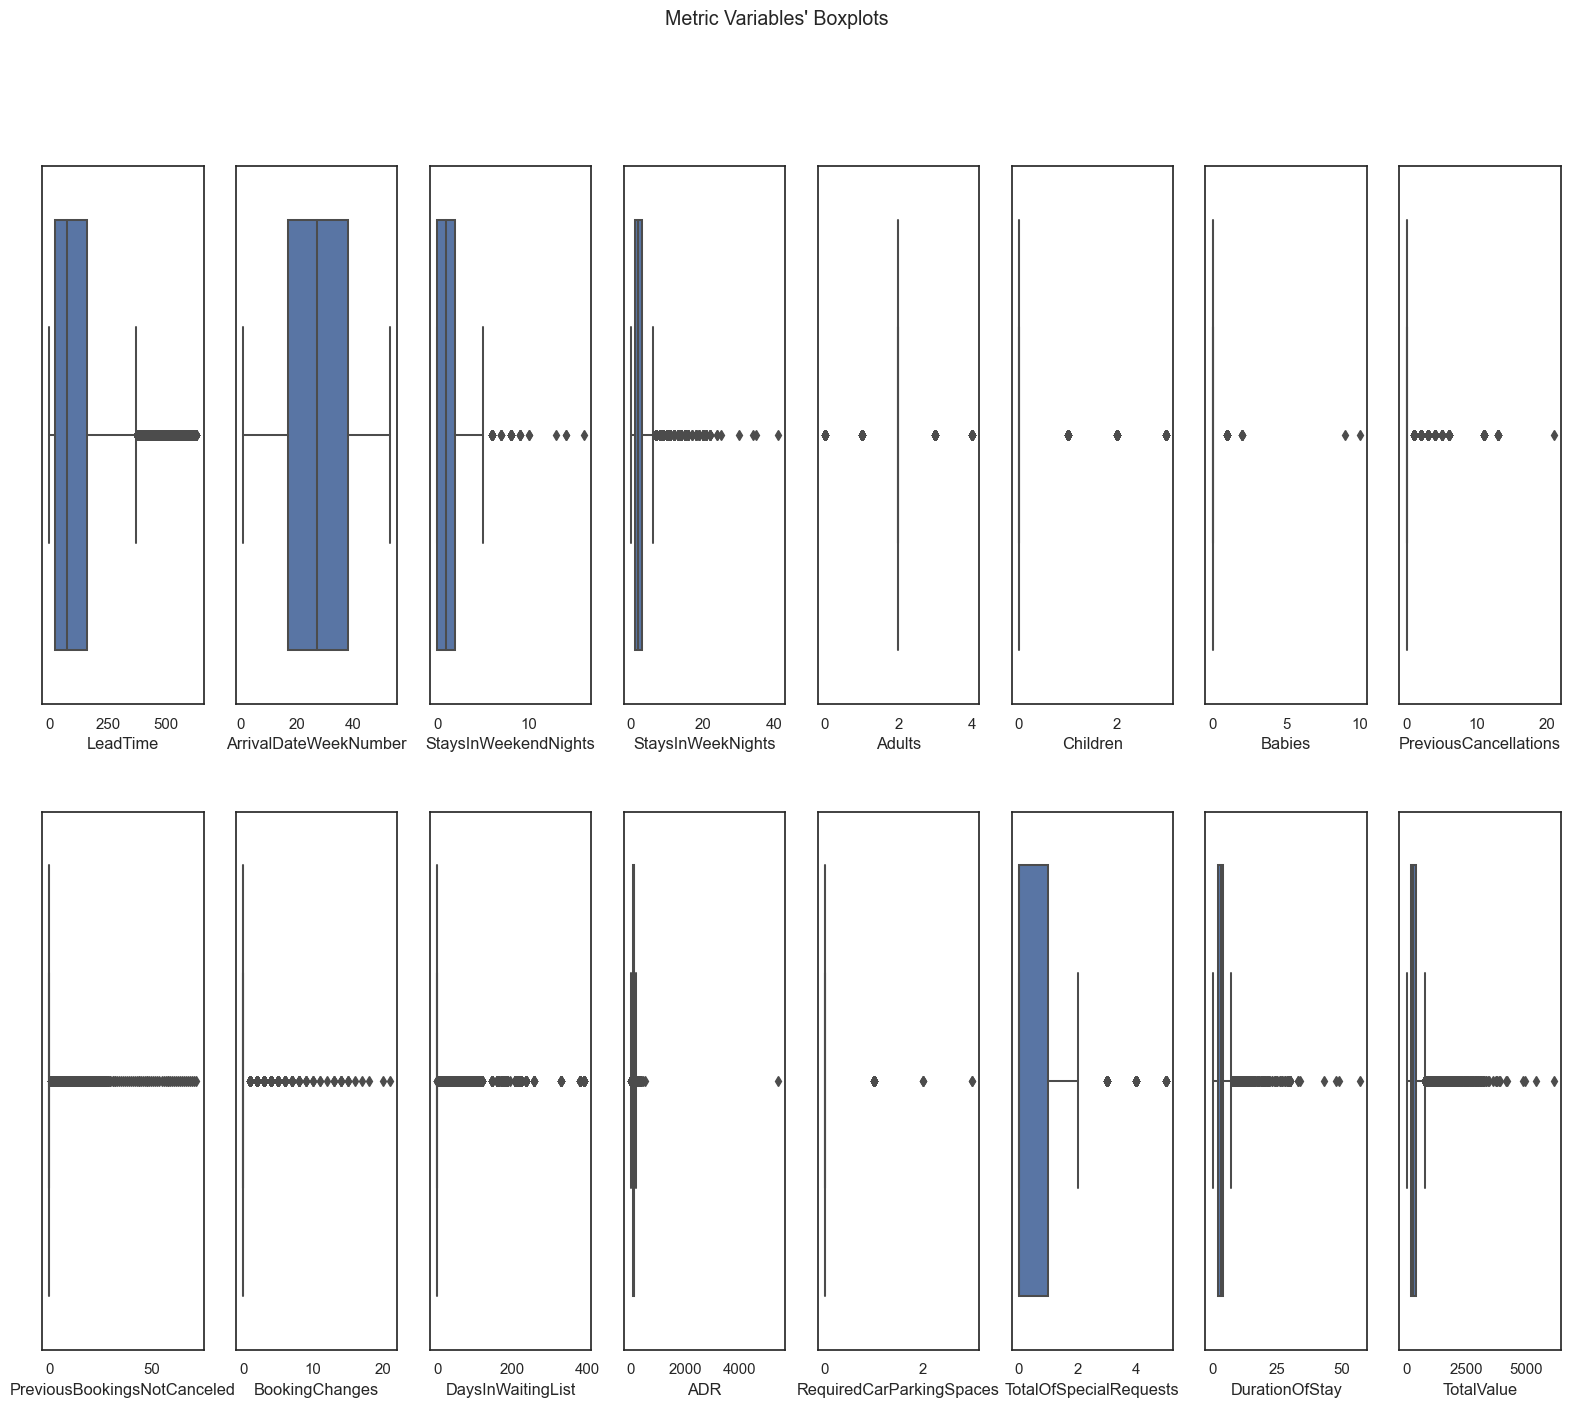

In [212]:
boxplot(data, metric_features)

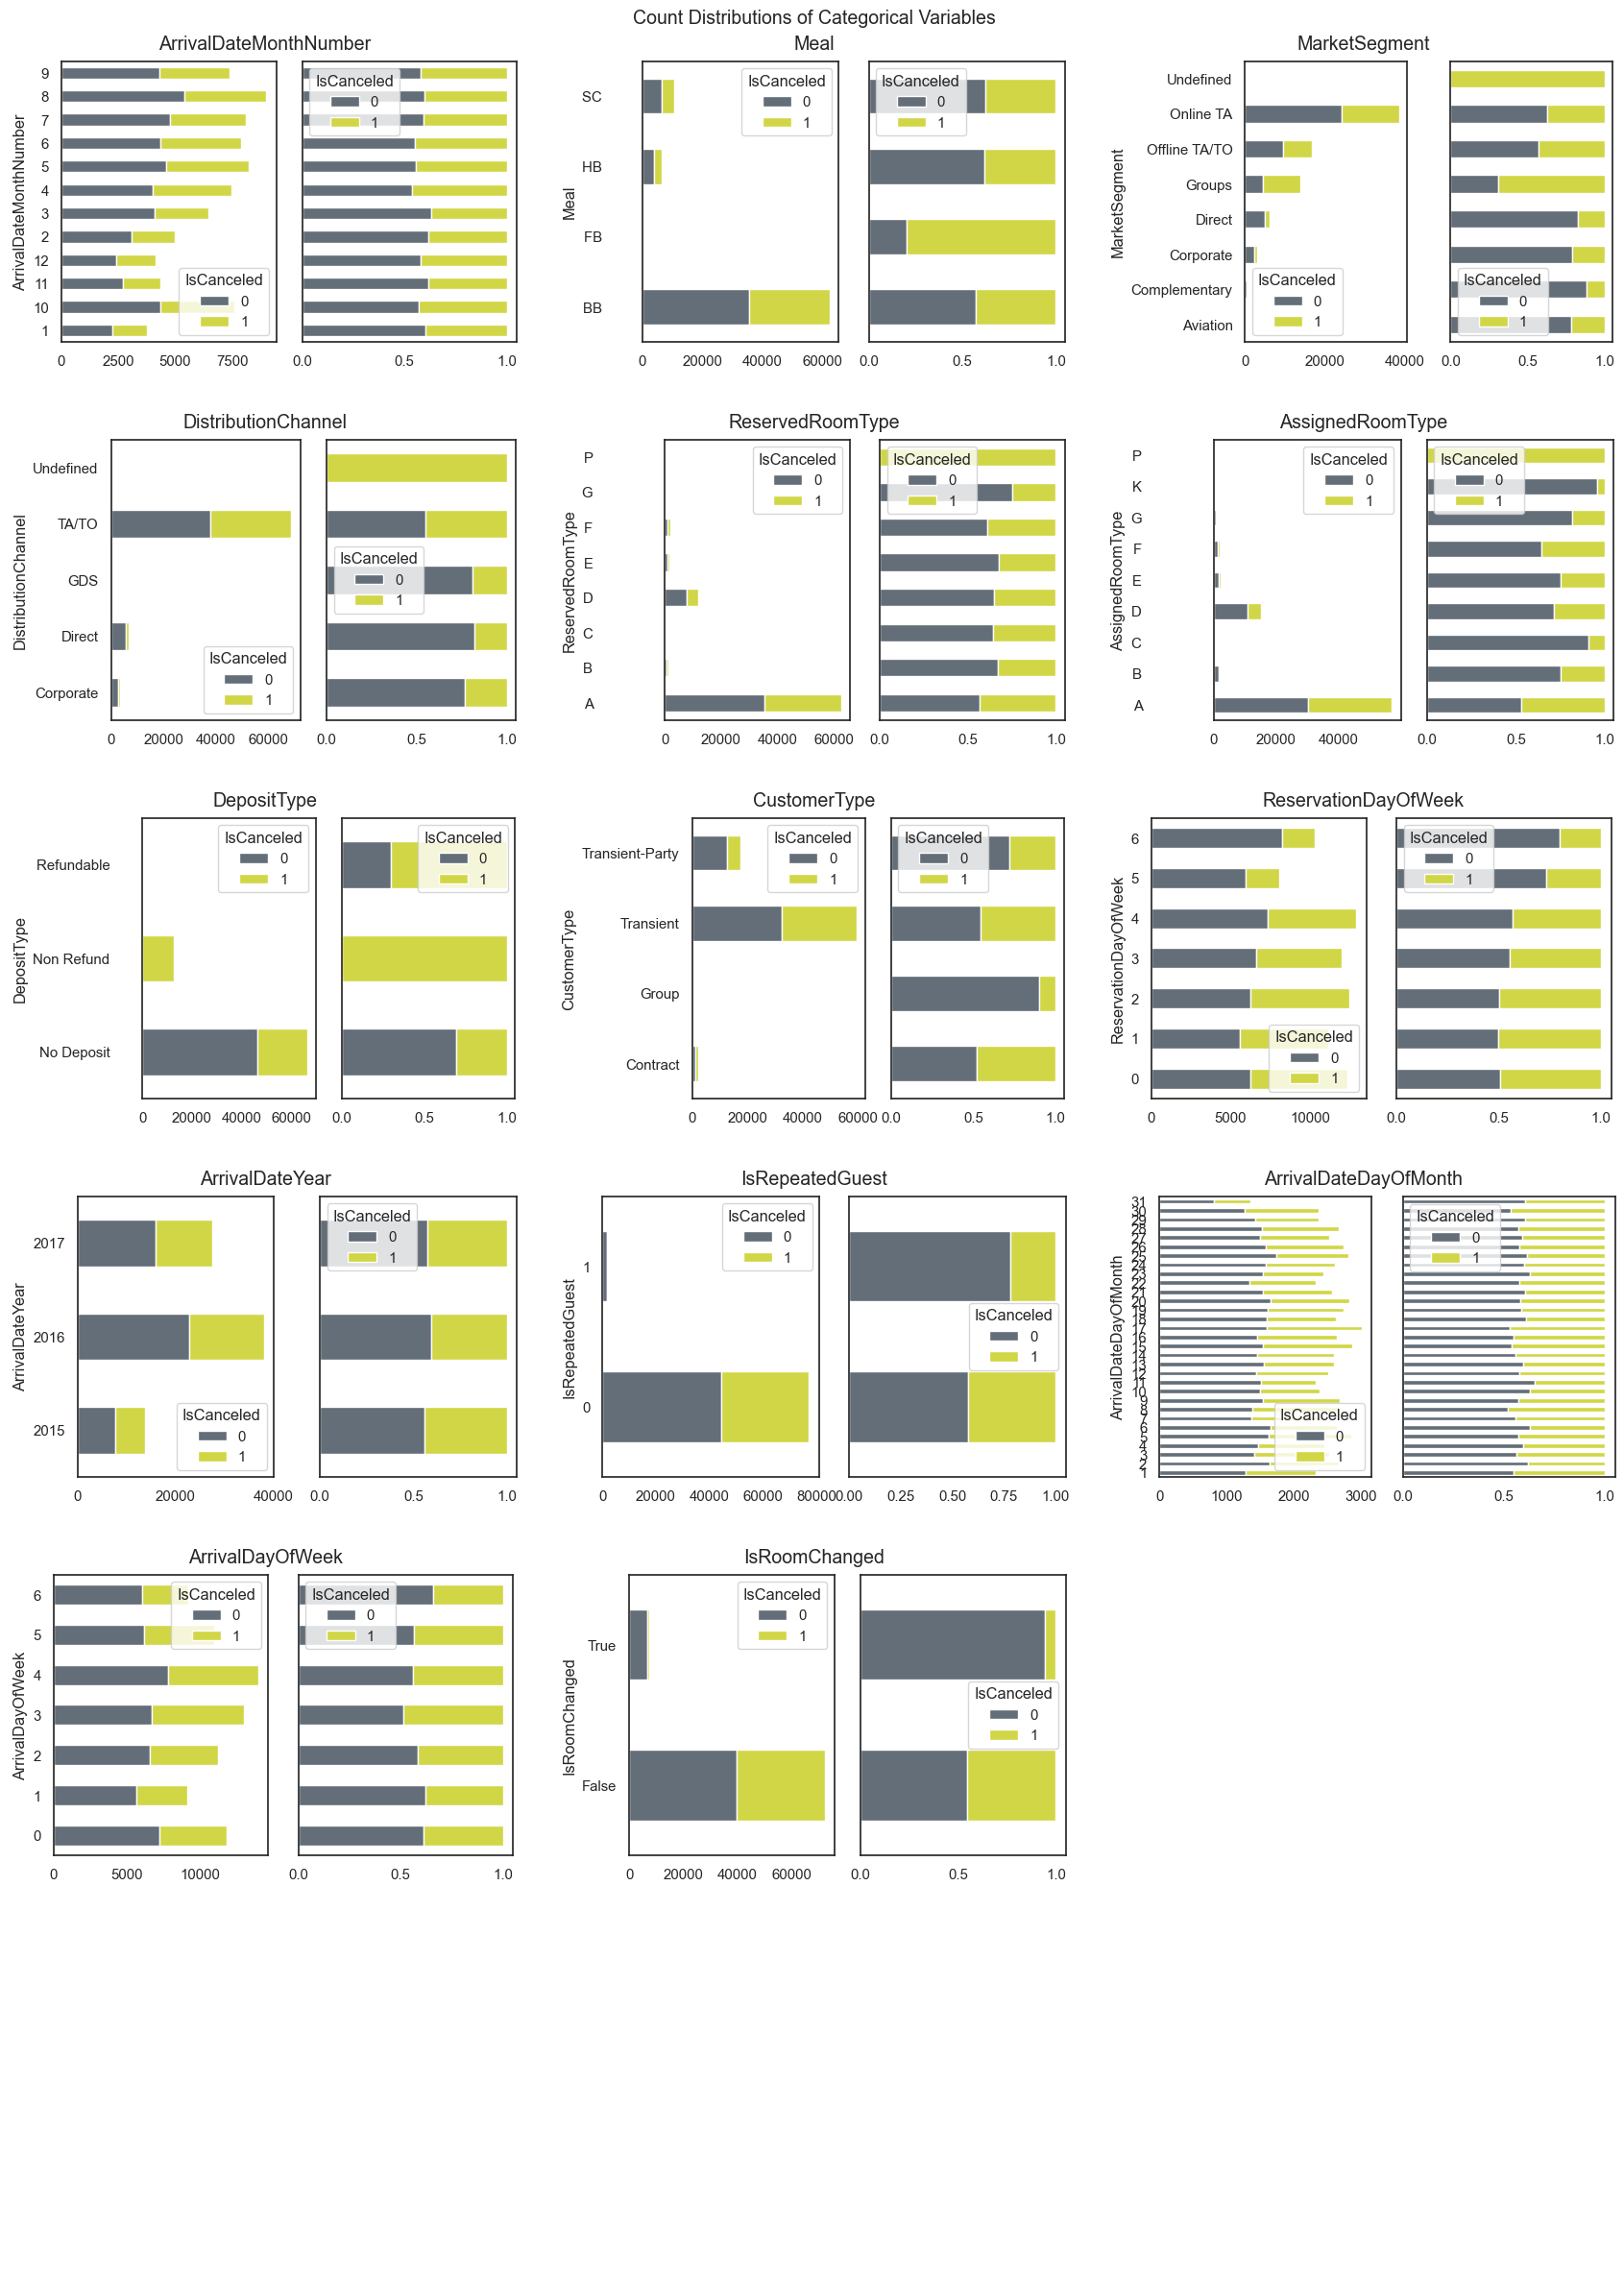

In [213]:
to_plot = ['ArrivalDateMonthNumber', 'Meal','MarketSegment','DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
'DepositType', 'CustomerType', 'ReservationDayOfWeek', 'ArrivalDateYear', 'IsRepeatedGuest', 'ArrivalDateDayOfMonth', "ArrivalDayOfWeek",
"IsRoomChanged"]

plot_cat_counts(data, to_plot)

<b> Categorical Features that show they might be important for the model: </b> IsRoomChanged, DepositType, IsRepeatedGuest, CustomerType, DistributionChannel, MarketSegment

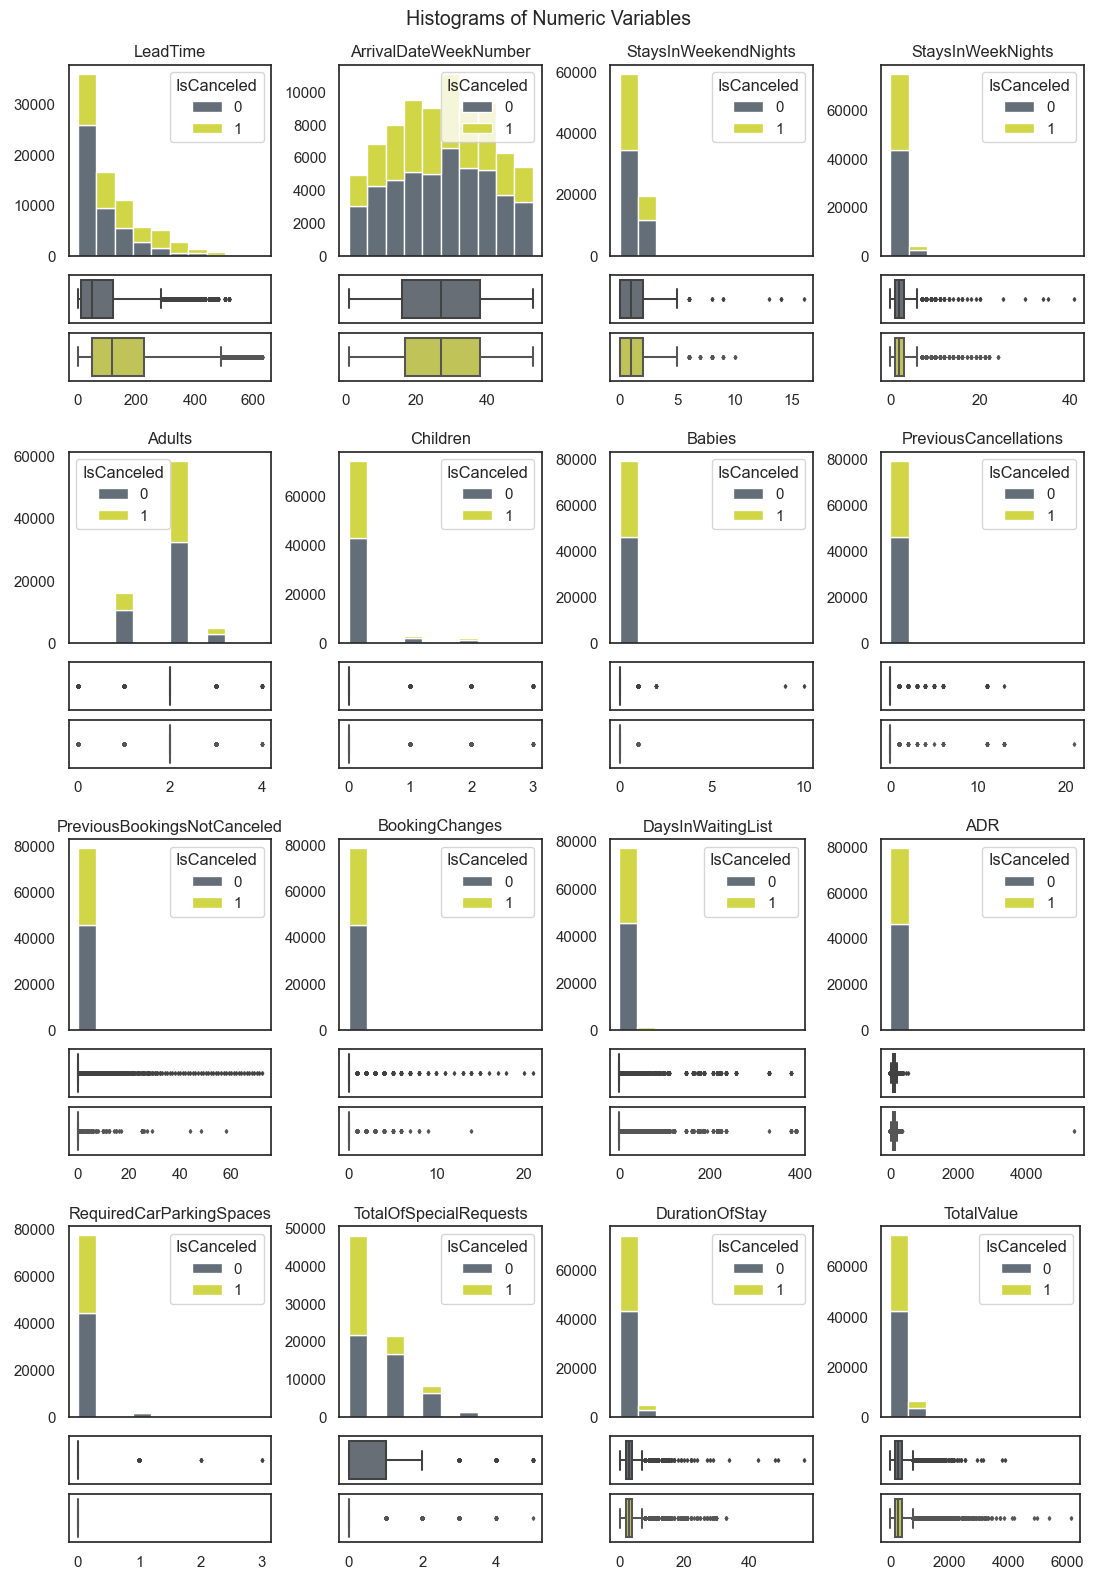

In [214]:
plot_histograms_boxplots(data, metric_features)

<b> Metric Features that show they might be important for the model: </b> LeadTime, TotalOfSpecialRequests

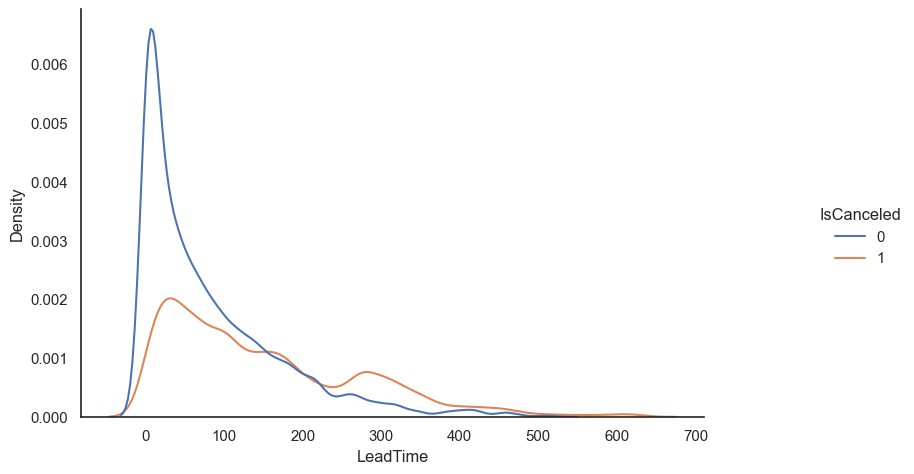

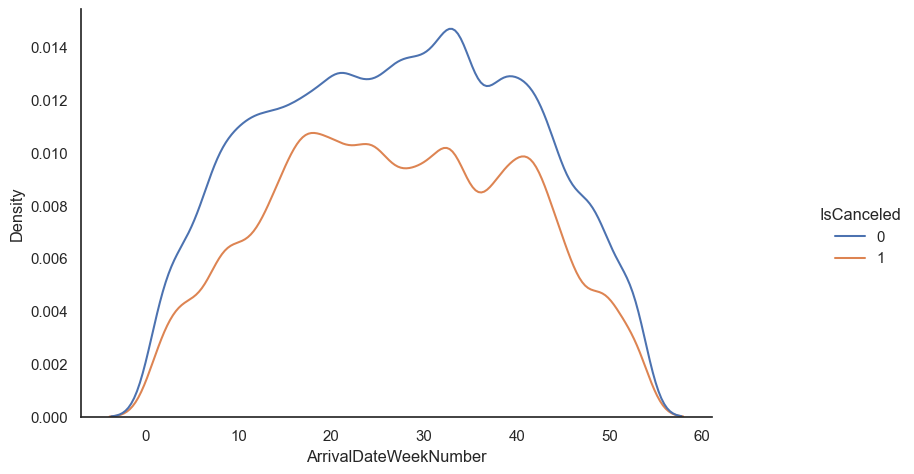

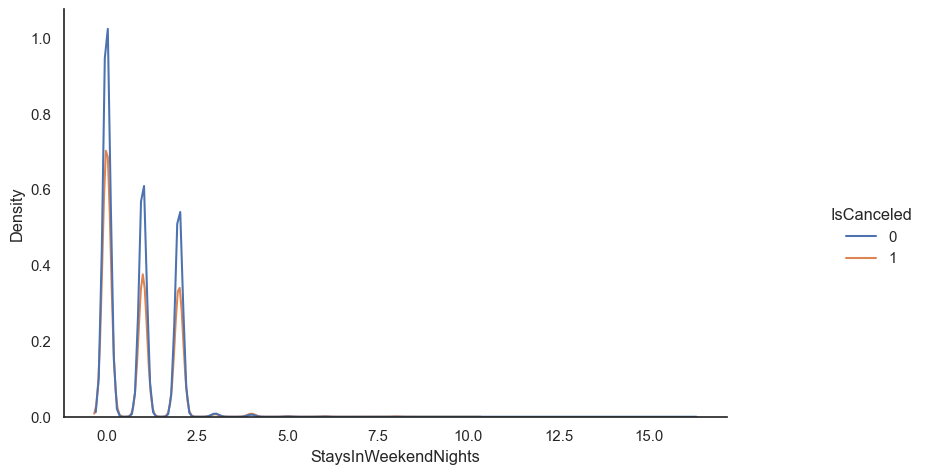

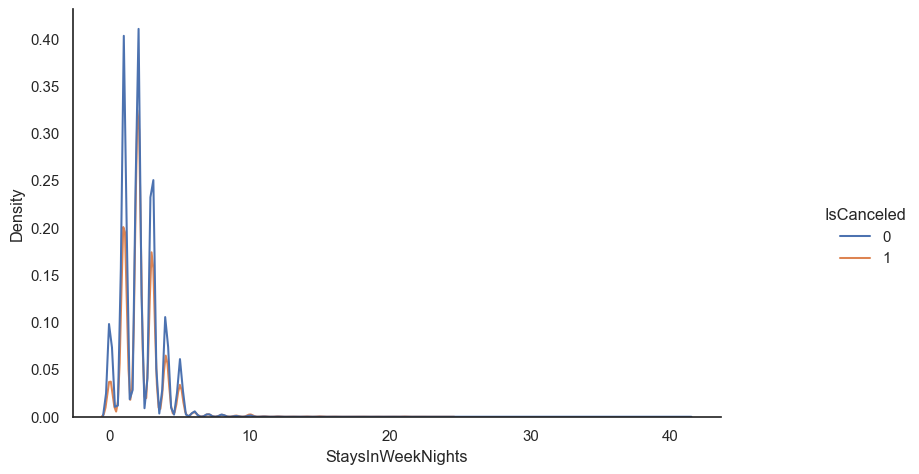

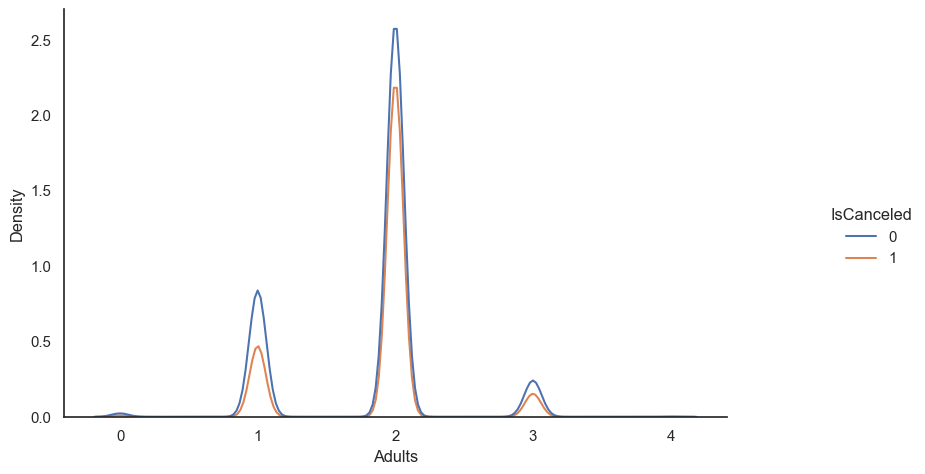

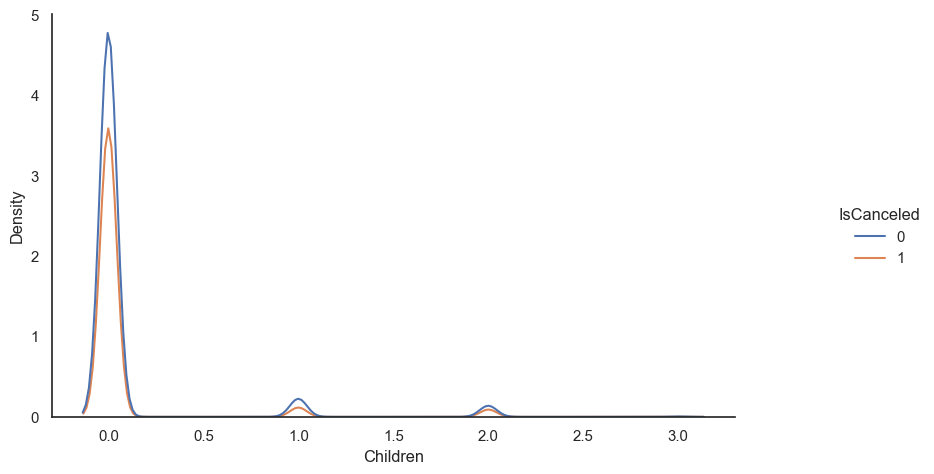

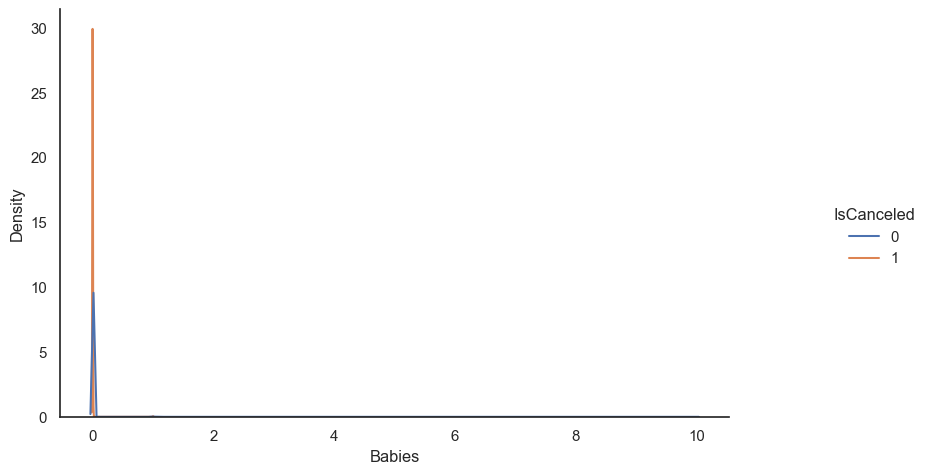

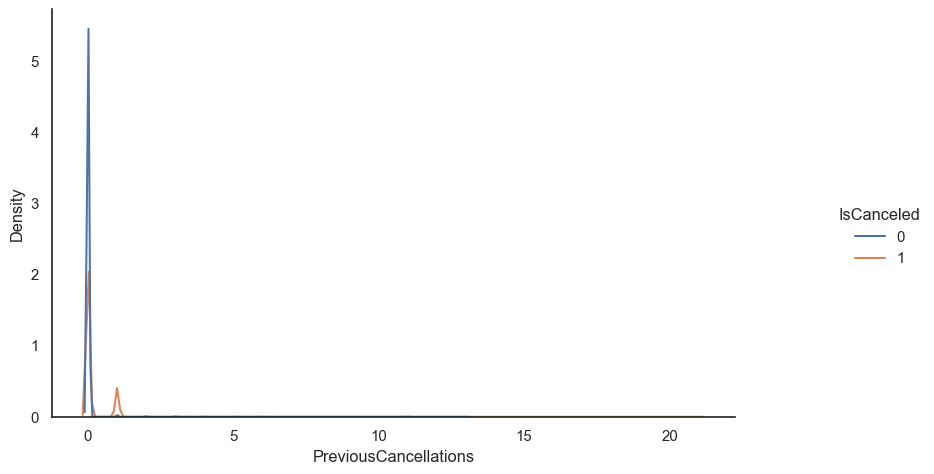

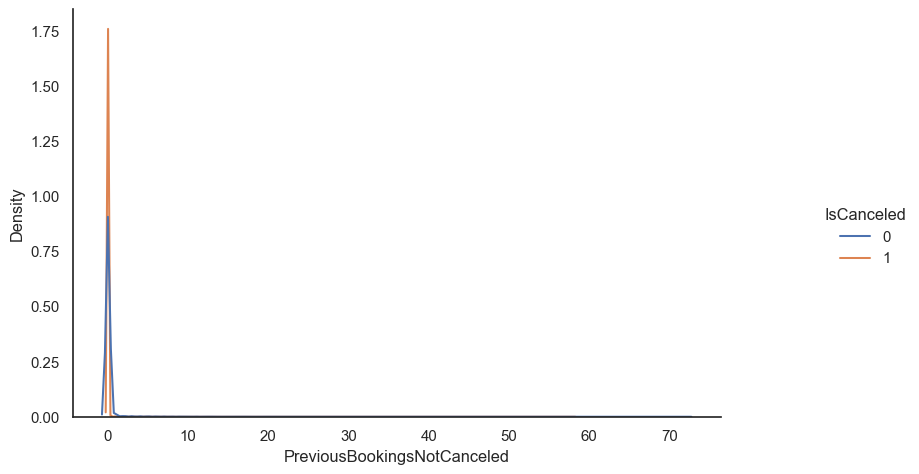

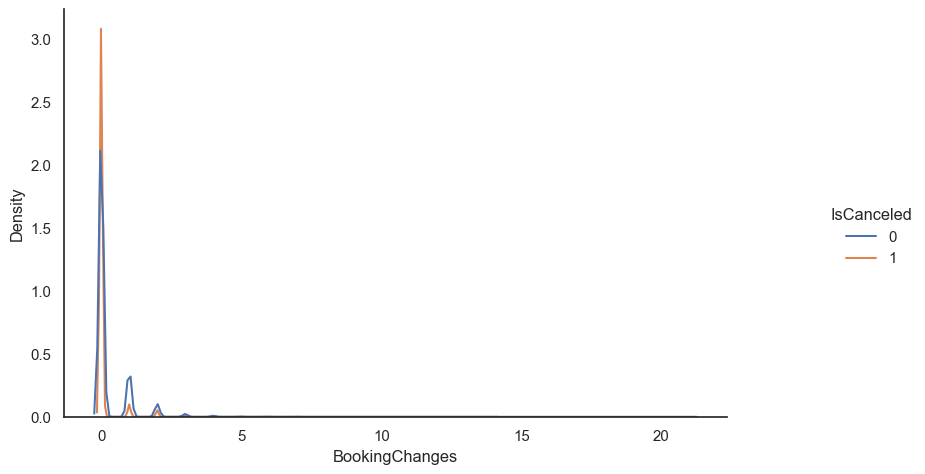

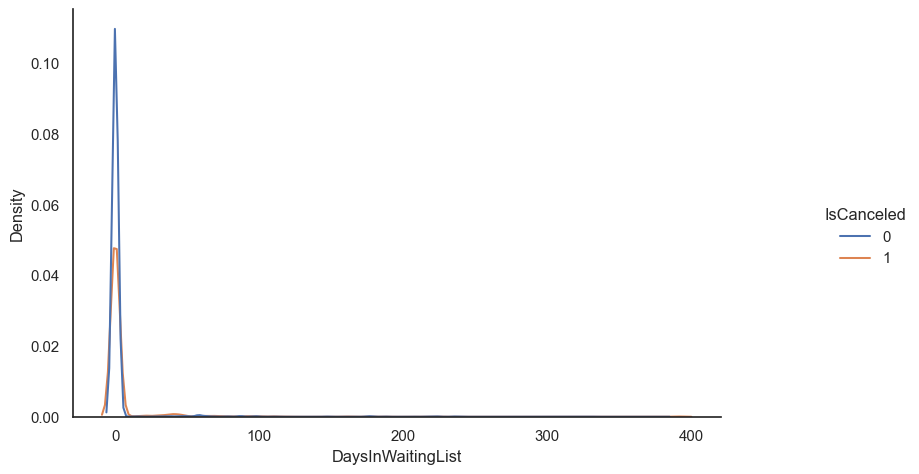

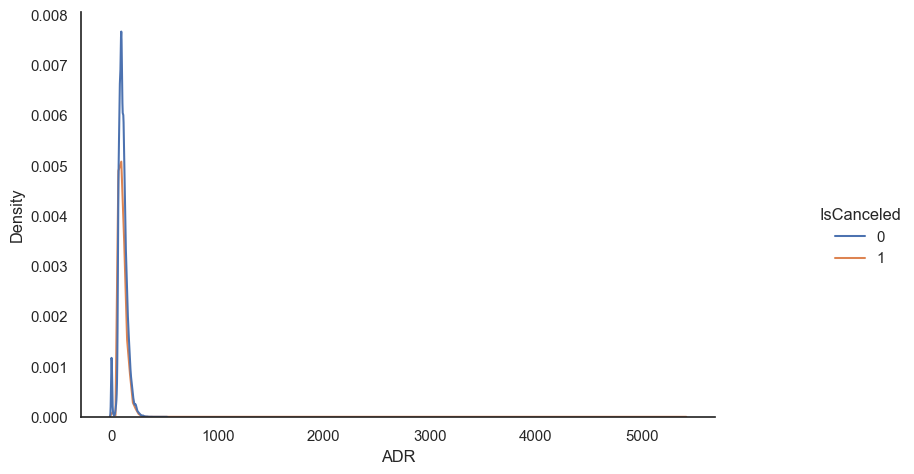

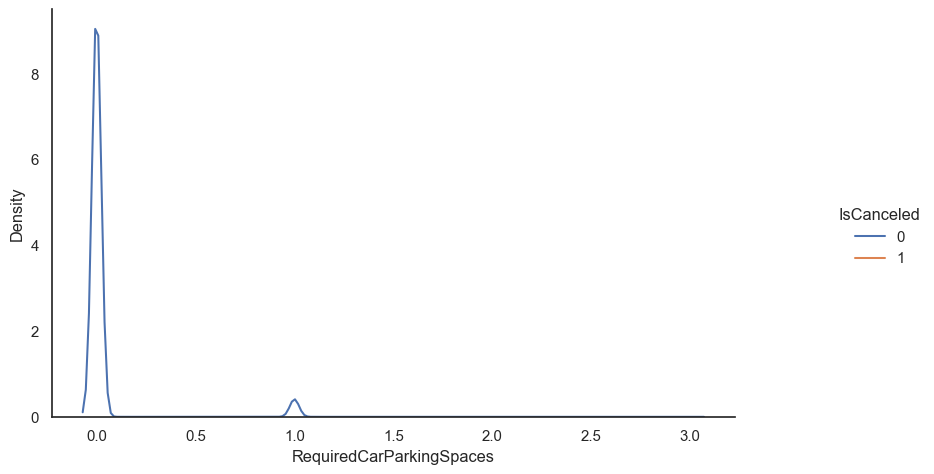

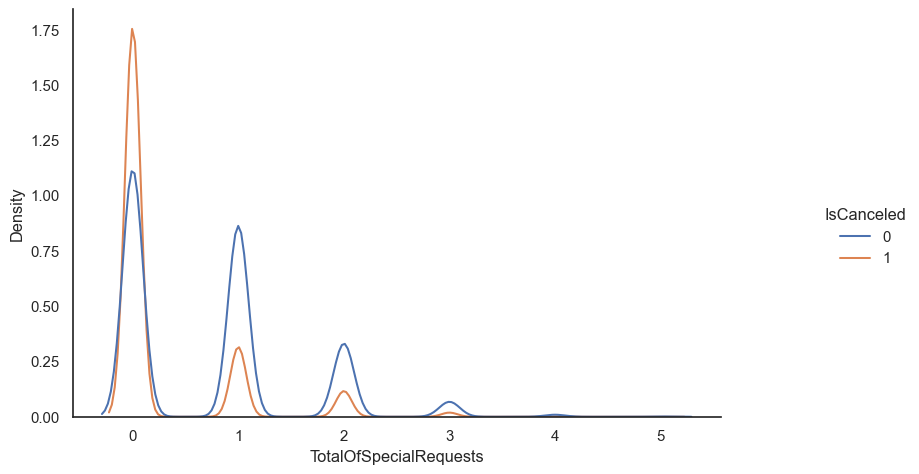

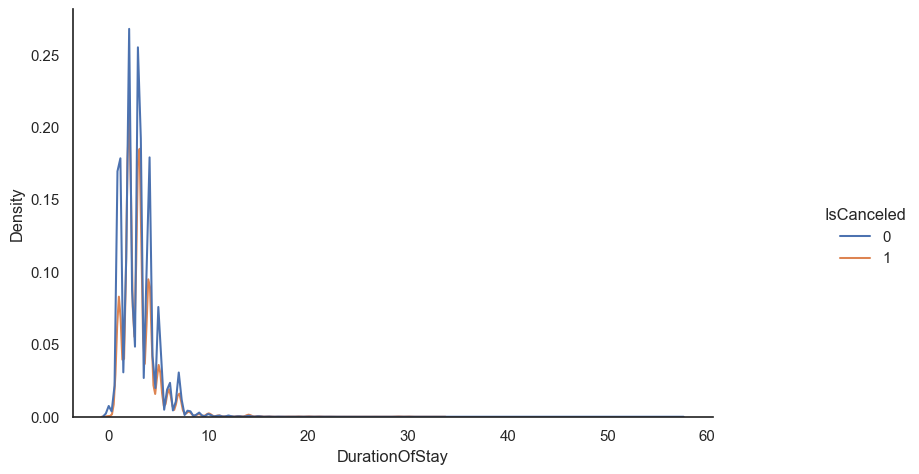

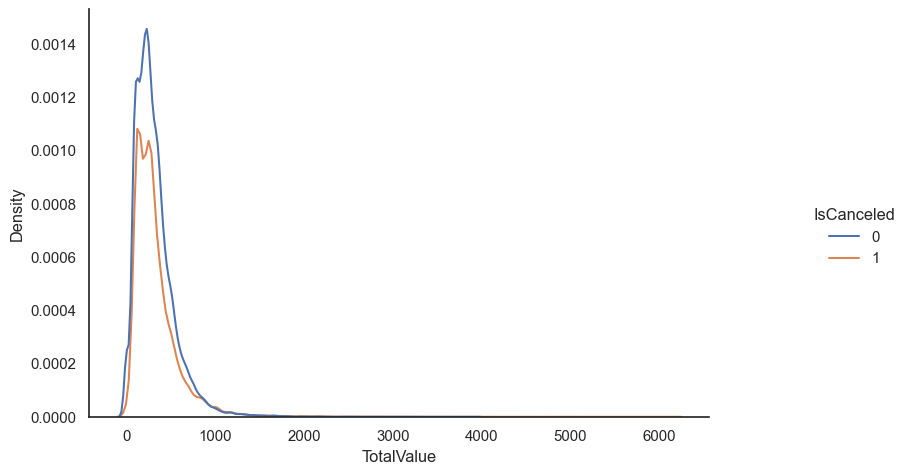

In [215]:
for feature in metric_features:
    g = sns.displot(data=data, x=feature, hue="IsCanceled", kind="kde");
    g.fig.set_size_inches(10,5)

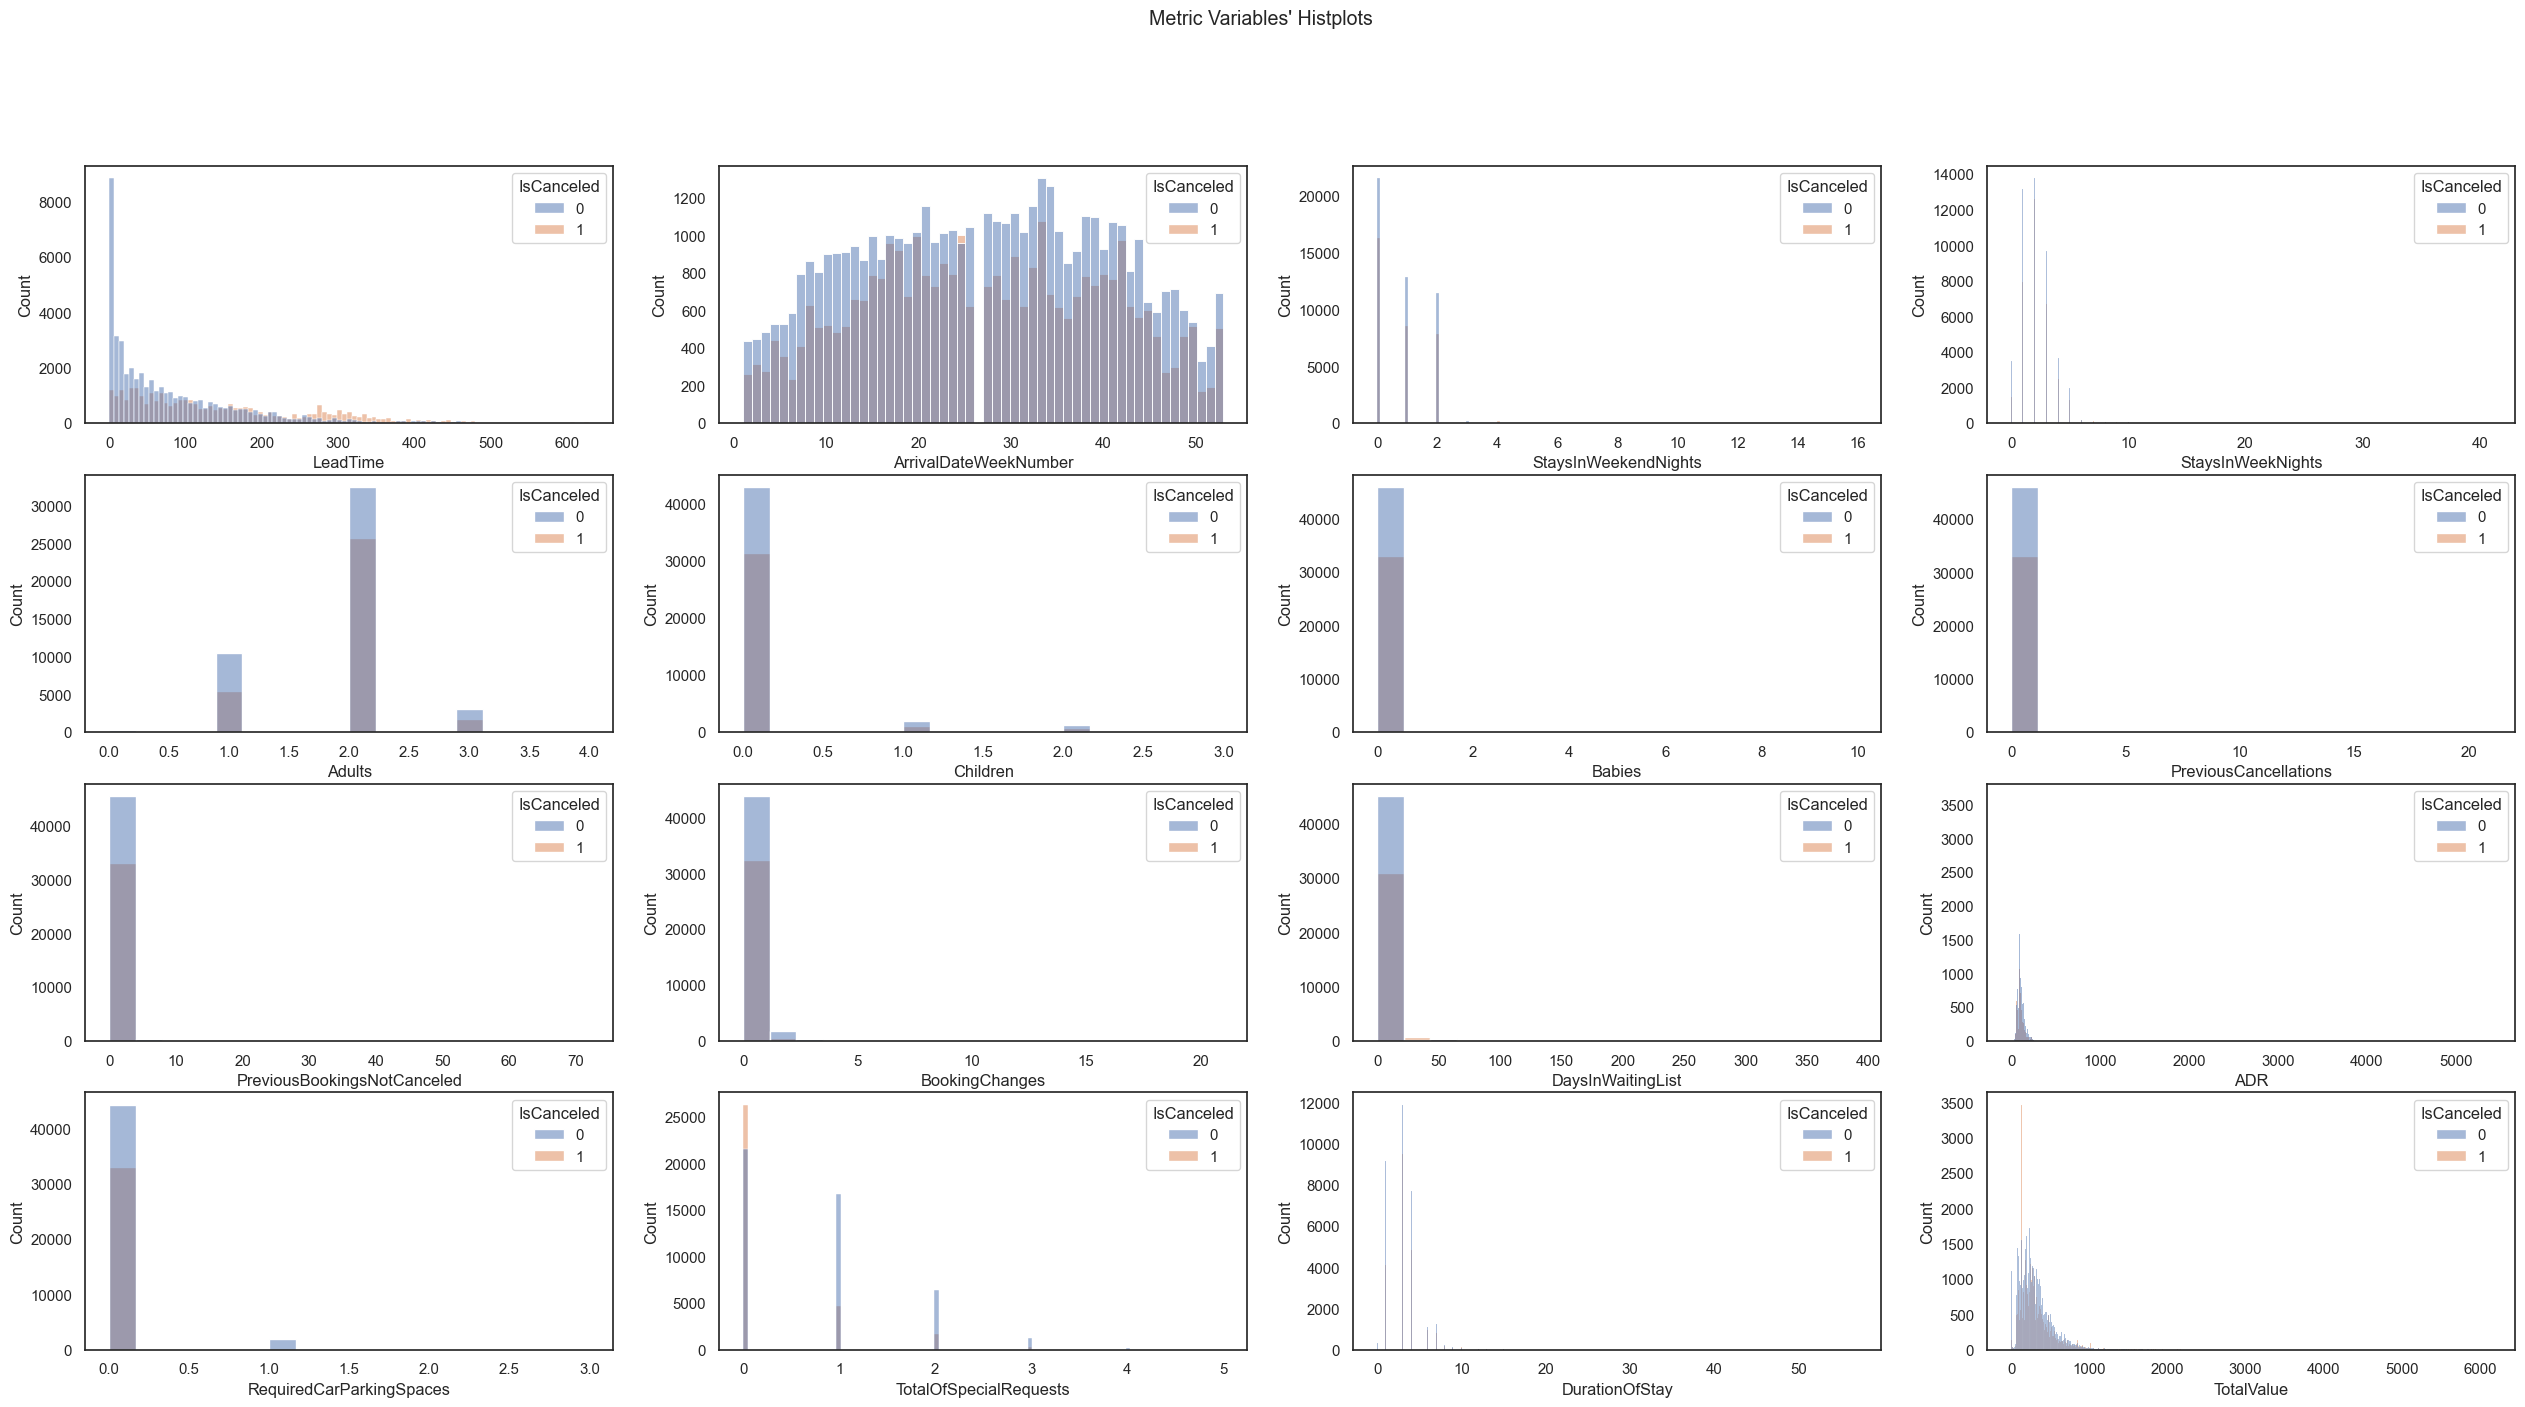

In [216]:
sns.set(style='white')

fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(32, 16))

for ax, feat in zip(axes.flatten(), metric_features):
    # sns.histplot(data[feat], ax=ax, hue = "IsCanceled")
    sns.histplot(data=data, x=feat, hue="IsCanceled", ax = ax)
    # ax.set_title(feat, y=-0.11)

title = "Metric Variables' Histplots"
plt.suptitle(title)
plt.show()

In [217]:
# Trying to understand the average room economic value
data.groupby("ReservedRoomType")["ADR"].count()

ReservedRoomType
A                   62595
B                    1115
C                      14
D                   11768
E                    1553
F                    1791
G                     484
P                      10
Name: ADR, dtype: int64

In [218]:
data[(data["AssignedRoomType"] == "P               ")]
# data.ReservedRoomType.unique()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
20591,1,0,2016,47,17,4,11,0,0,0,SC,PRT,Corporate,Direct,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-11-17,15,0.0,11,2016-11-17,3,17,46,11,3,False
21184,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,False
21185,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,False
21189,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,False
25847,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,False
25848,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,False
25849,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,False
25850,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,False
32907,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,False
32908,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,False


In [219]:
#exploring records with ADR = 0
data.loc[data["ADR"] == 0]#.value_counts("ReservationStatus")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03,2,0.0,7,2015-07-01,2,3,27,7,4,False
134,1,0,2015,29,15,0,1,2,0,0,SC,PRT,Direct,Direct,0,0,0,A,F,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2015-07-15,1,0.0,7,2015-07-15,2,15,29,7,2,True
139,0,0,2015,29,15,2,5,2,0,0,SC,PRT,Direct,Direct,0,0,0,F,A,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-22,7,0.0,7,2015-07-15,2,22,30,7,2,True
166,0,18,2015,29,18,1,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-20,2,0.0,7,2015-07-18,5,20,30,7,0,False
196,0,12,2015,29,18,2,2,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-22,4,0.0,7,2015-07-18,5,22,30,7,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78571,0,78,2017,34,23,0,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,98,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,0,0.0,8,2017-08-23,2,23,34,8,2,True
78702,0,1,2017,34,24,0,1,2,1,0,BB,PRT,Complementary,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,0.0,0,3,Check-Out,2017-08-25,1,0.0,8,2017-08-24,3,25,34,8,4,True
78903,0,1,2017,35,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2017-08-27,0,0.0,8,2017-08-27,6,27,34,8,6,False
79042,0,518,2017,34,26,2,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-29,3,0.0,8,2017-08-26,5,29,35,8,1,False


In [220]:
#the same day different rooms have different ADRs
data.loc[(data["ArrivalDateYear"] == 2015) &
(data["ArrivalDateMonthNumber"] == 9) & 
(data["ArrivalDateDayOfMonth"] == 2)].sort_values("ADR")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [221]:
# data.loc[(data["ADR"] == 0) & (data["MarketSegment"] != "Complementary")]
data.loc[(data["ADR"] == 0)].value_counts("MarketSegment")

MarketSegment
Complementary    508
Offline TA/TO    236
Online TA        173
Groups           144
Direct           111
Corporate         30
Aviation           6
dtype: int64

In [222]:
# Complementary also have non zero ADRs
data.loc[data["MarketSegment"] == "Complementary"].sort_values("ADR", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
37755,0,0,2015,39,26,1,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,1,No Deposit,NULL,NULL,0,Transient,170.0,0,0,Check-Out,2015-09-28,2,340.0,9,2015-09-26,5,28,40,9,0,False
45705,0,0,2016,13,20,1,0,2,0,0,BB,DEU,Complementary,TA/TO,0,0,0,A,E,0,No Deposit,NULL,NULL,0,Transient,139.0,0,0,Check-Out,2016-03-21,1,139.0,3,2016-03-20,6,21,12,3,0,True
40489,1,8,2017,11,15,0,1,1,0,0,BB,PRT,Complementary,Direct,1,1,1,A,A,0,No Deposit,NULL,46,0,Transient,79.0,0,0,Canceled,2017-03-07,1,79.0,3,2017-03-15,2,7,10,3,1,False
40071,0,2,2015,46,9,1,2,1,0,0,BB,USA,Complementary,Direct,0,0,0,A,A,0,No Deposit,45,NULL,0,Group,79.0,0,0,Check-Out,2015-11-12,3,237.0,11,2015-11-09,0,12,46,11,3,False
61678,0,32,2016,47,15,0,2,2,0,0,BB,DEU,Complementary,Direct,0,0,0,E,E,0,No Deposit,NULL,NULL,0,Transient,75.0,0,1,Check-Out,2016-11-17,2,150.0,11,2016-11-15,1,17,46,11,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38583,1,1,2015,42,13,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Canceled,2015-10-13,1,0.0,10,2015-10-13,1,13,42,10,1,False
38192,0,0,2016,17,21,0,1,1,0,0,BB,PRT,Complementary,Direct,1,0,1,G,G,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2016-04-22,1,0.0,4,2016-04-21,3,22,16,4,4,False
38191,0,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2015-10-07,1,0.0,10,2015-10-06,1,7,41,10,2,False
38149,1,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,No-Show,2015-10-06,1,0.0,10,2015-10-06,1,6,41,10,1,False


In [223]:
data.value_counts("MarketSegment")

MarketSegment
Online TA        38748
Offline TA/TO    16747
Groups           13975
Direct            6093
Corporate         2986
Complementary      542
Aviation           237
Undefined            2
dtype: int64

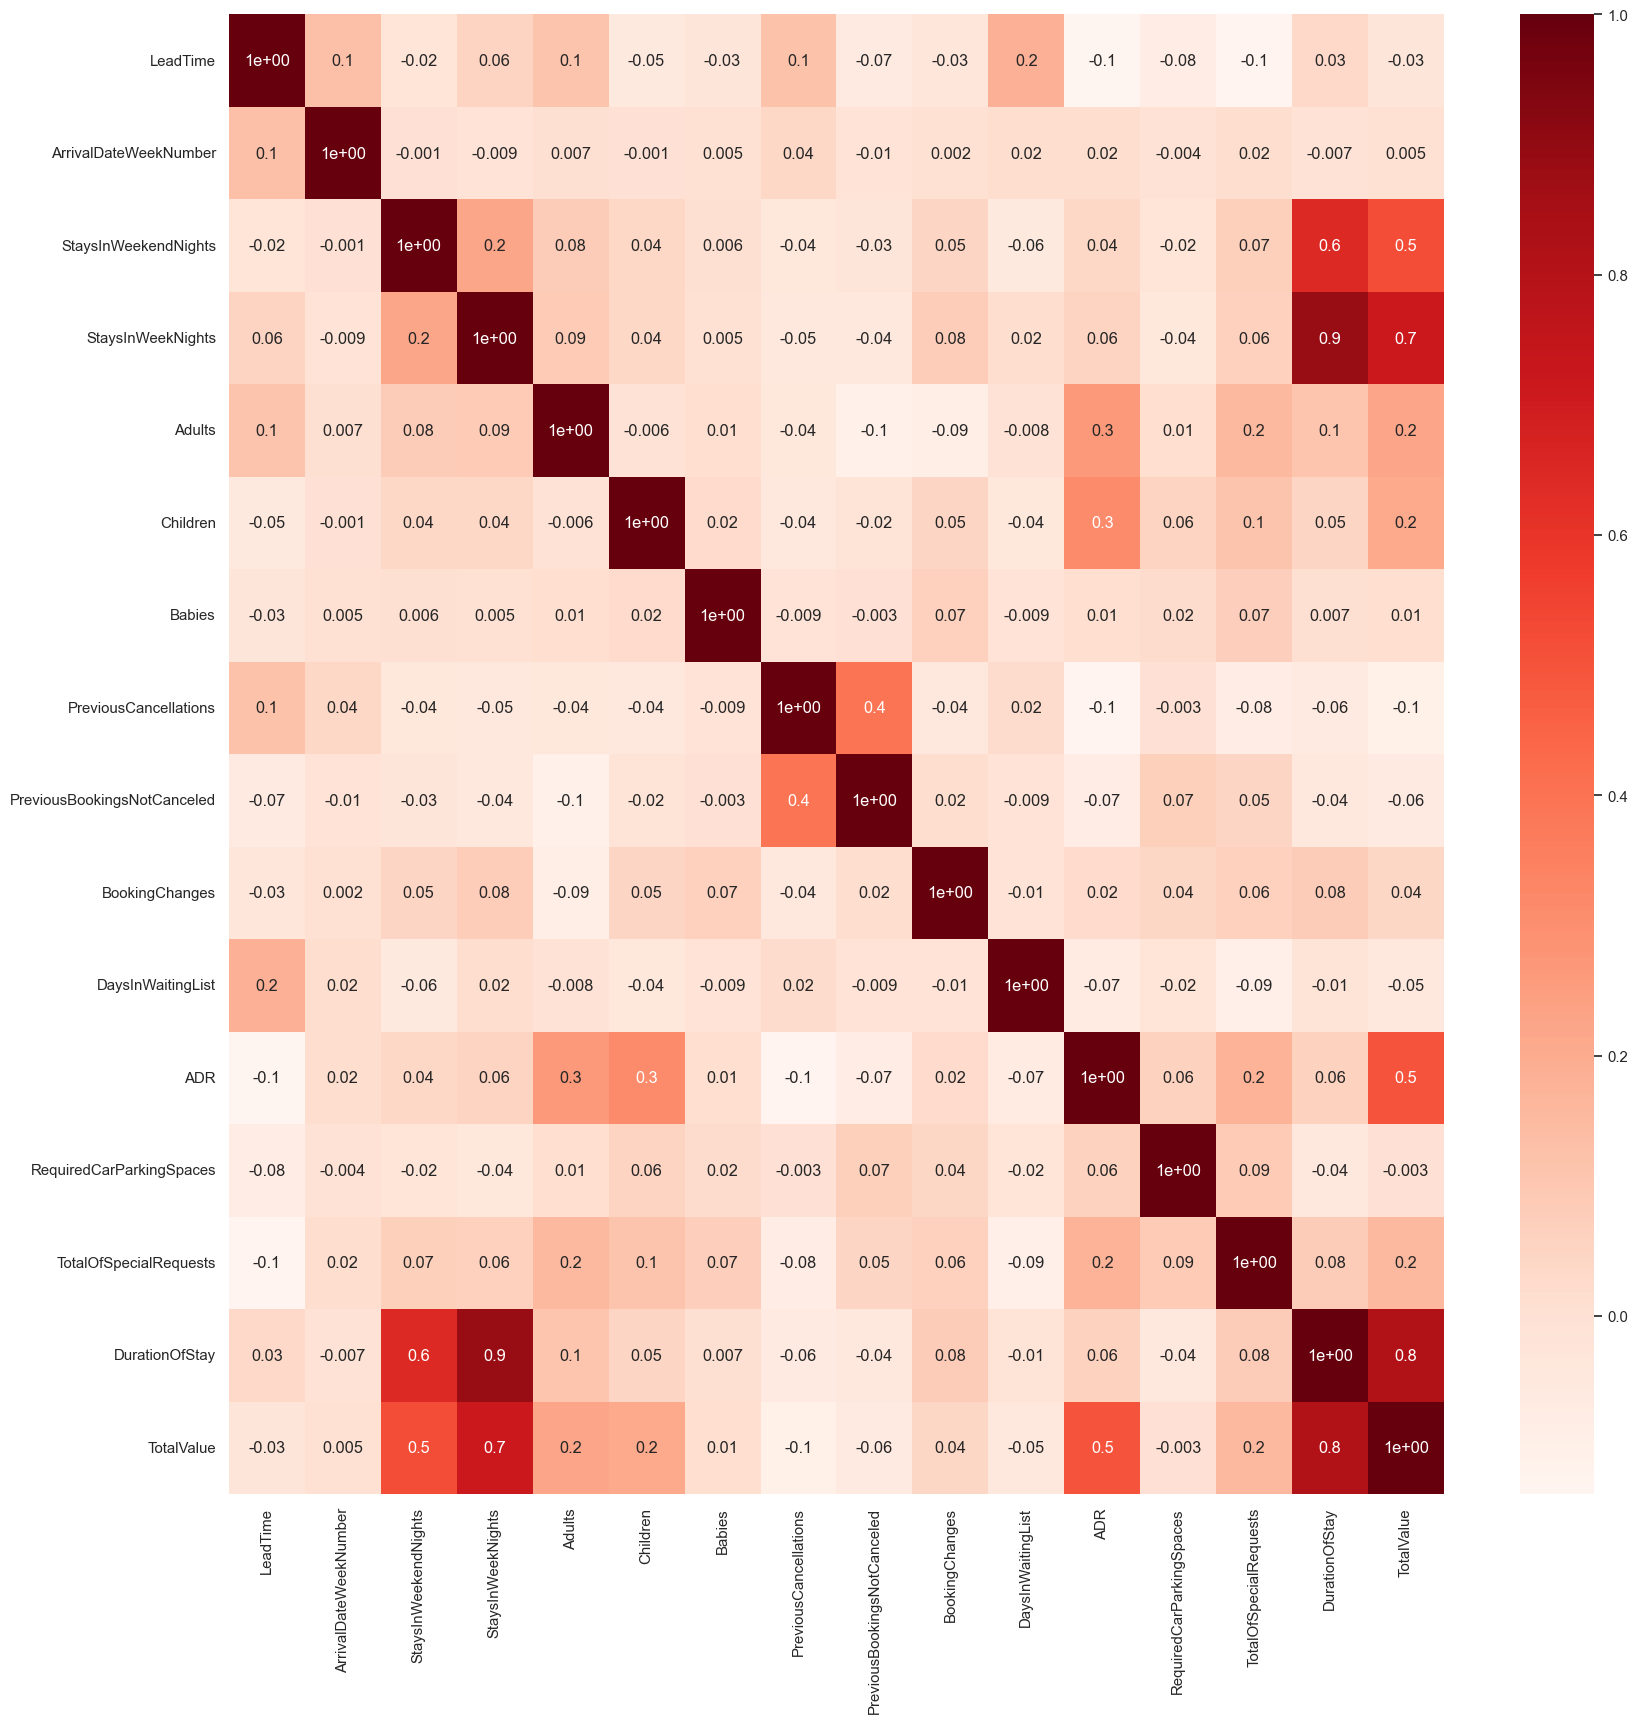

In [224]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_heatmap(np.round(data[metric_features].corr(),3))

## OUTLIERS TREATEMENT

In [225]:
data_out = data.copy()
# data_out1 = data.copy()

In [226]:
# def Isolation_Forest (data):
   
    
#     #this algorithm only works with data without missing values
#     data_out = data[numeric_features]
#     #data_out = data.select_dtypes(include=np.number).set_index(data.index)
#     forest_model = IsolationForest(n_estimators=20,contamination=0.01)
#     forest_model.fit(data_out)
#     anomally = forest_model.decision_function(data_out)
#     predict_outcome = forest_model.predict(data_out)
    
#     #creating a dataset with the density scores and the predicted outcome (-1==outlier; 1==normal obs)
#     data_out_score = pd.DataFrame(data=anomally, index=data_out.index)
#     data_out_score['predicted_outcome'] = predict_outcome
#     return(data_out_score)

# def Isolation_Forest_test (data):
#     outliers = Isolation_Forest(data)
#     outliers_test = pd.DataFrame(index = data.index)
#     outliers_test['predicted_outcome'] = outliers['predicted_outcome']
#     outliers_test.loc[outliers_test['predicted_outcome']==1, 'predicted_outcome']= 0 
#     outliers_test.loc[outliers_test['predicted_outcome']==-1, 'predicted_outcome']= 1
#     return(outliers_test)

# #data_IF = Isolation_Forest(data_outliers)
# data_IF = Isolation_Forest_test(data_out)

In [227]:
# data_out["Outlier"] = data_IF["predicted_outcome"]

In [228]:
# for i in data_out.loc[:, data.select_dtypes(include=np.number).columns].columns:
#     col = np.array(data.columns)
#     col = col[col!=i]
#     for index , ii in enumerate(col):
#         plt.figure(index)
#         sns.scatterplot(data_out[i],data_out[ii],hue=data_out['Outlier'])
#         plt.show()

In [229]:
ee = OneClassSVM(nu=0.03)
yhat = ee.fit_predict(data_out[metric_features])
# yhat1 = ee.fit_predict(data_out[numeric_features])

In [230]:
data_out['Outliers'] = yhat
# data_out1['Outliers'] = yhat1
data_out_rem= data_out[data_out['Outliers']==1]
# data_out_rem1= data_out1[data_out1['Outliers']==1]

Percentage kept:  0.9699735282995083


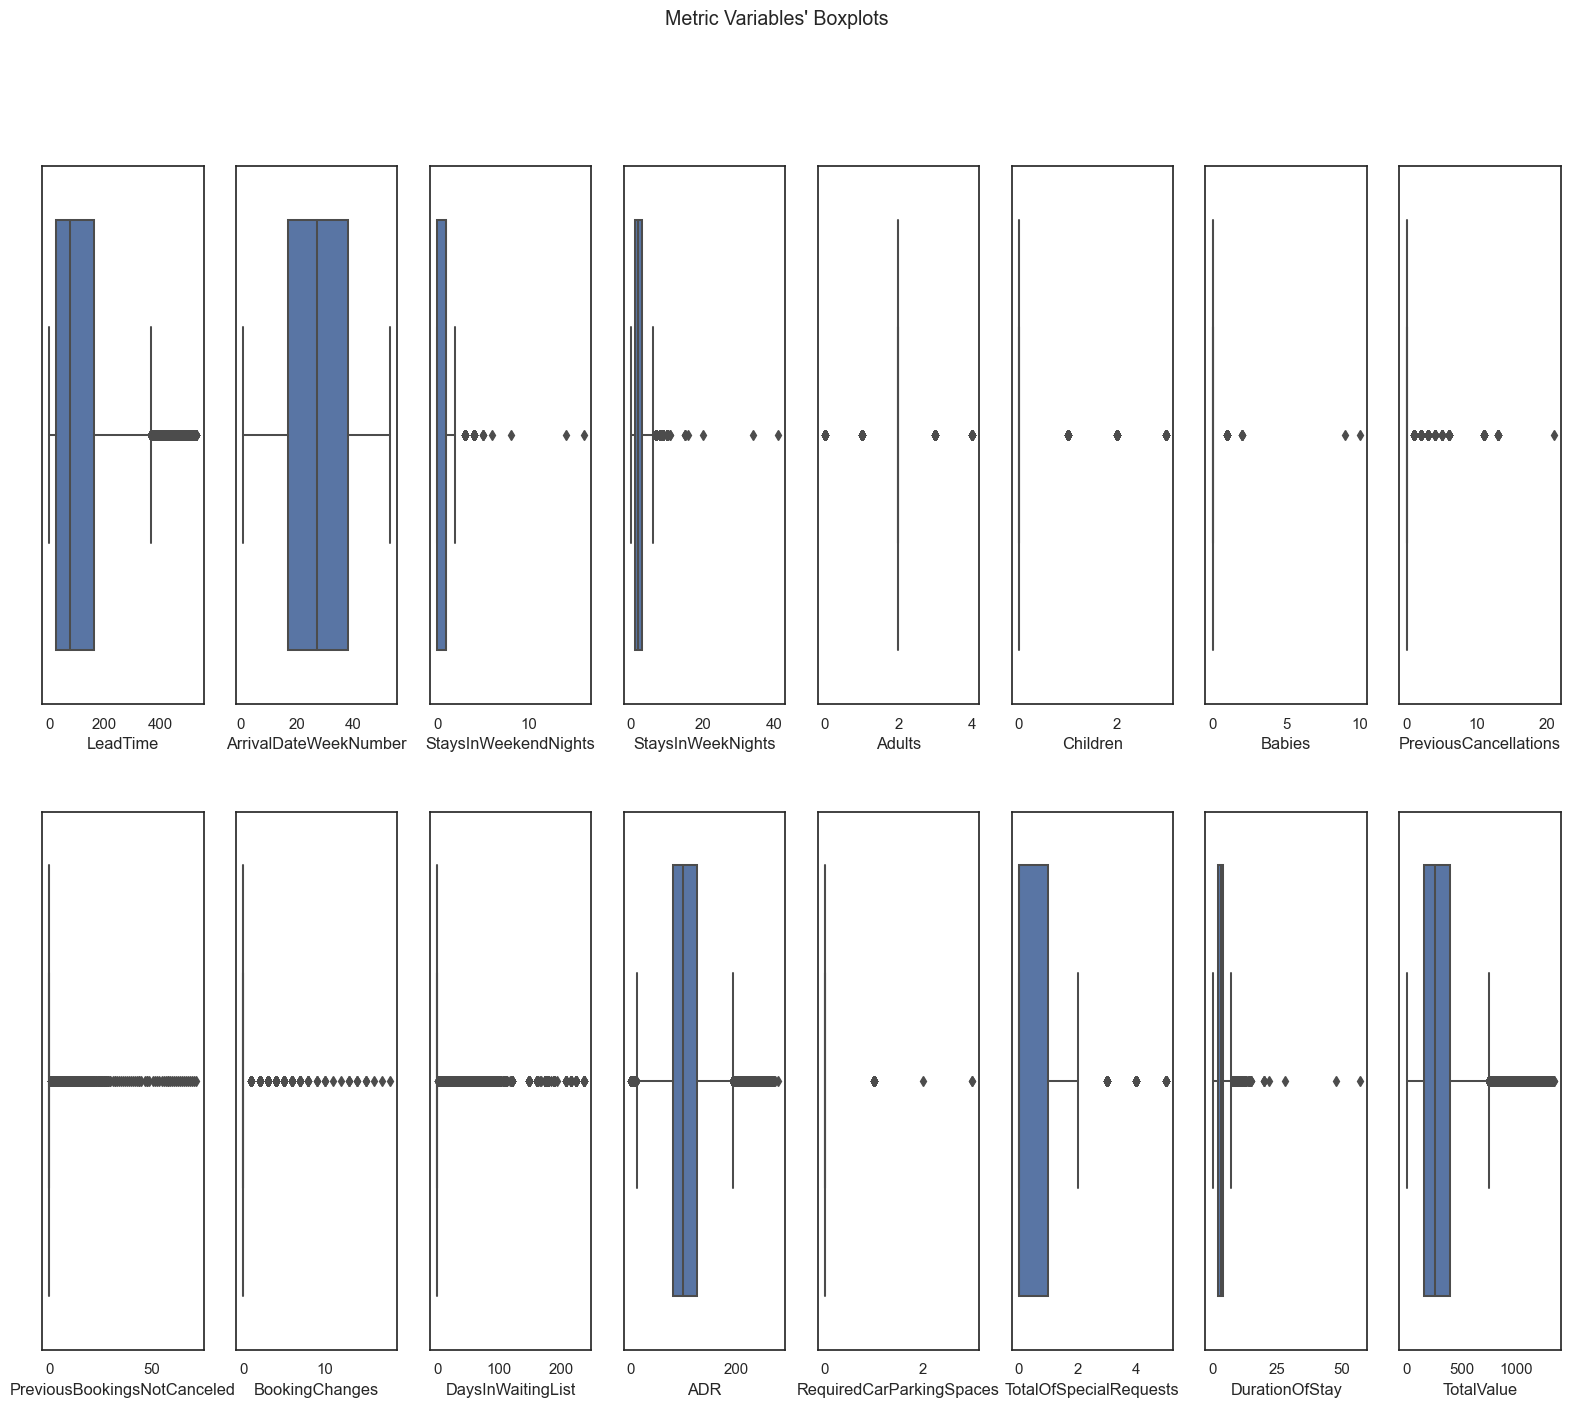

In [231]:
# print("Percentage kept: " , len(data_out_rem) / len(data_out))
# boxplot(data_out_rem, numeric_features)
# print("Percentage kept: " , len(data_out_rem1) / len(data_out1))
# boxplot(data_out_rem1, numeric_features)
print("Percentage kept: " , len(data_out_rem) / len(data_out))
boxplot(data_out_rem, metric_features)
# print("Percentage kept: " , len(data_out_rem1) / len(data_out1))
# boxplot(data_out_rem1, metric_features)

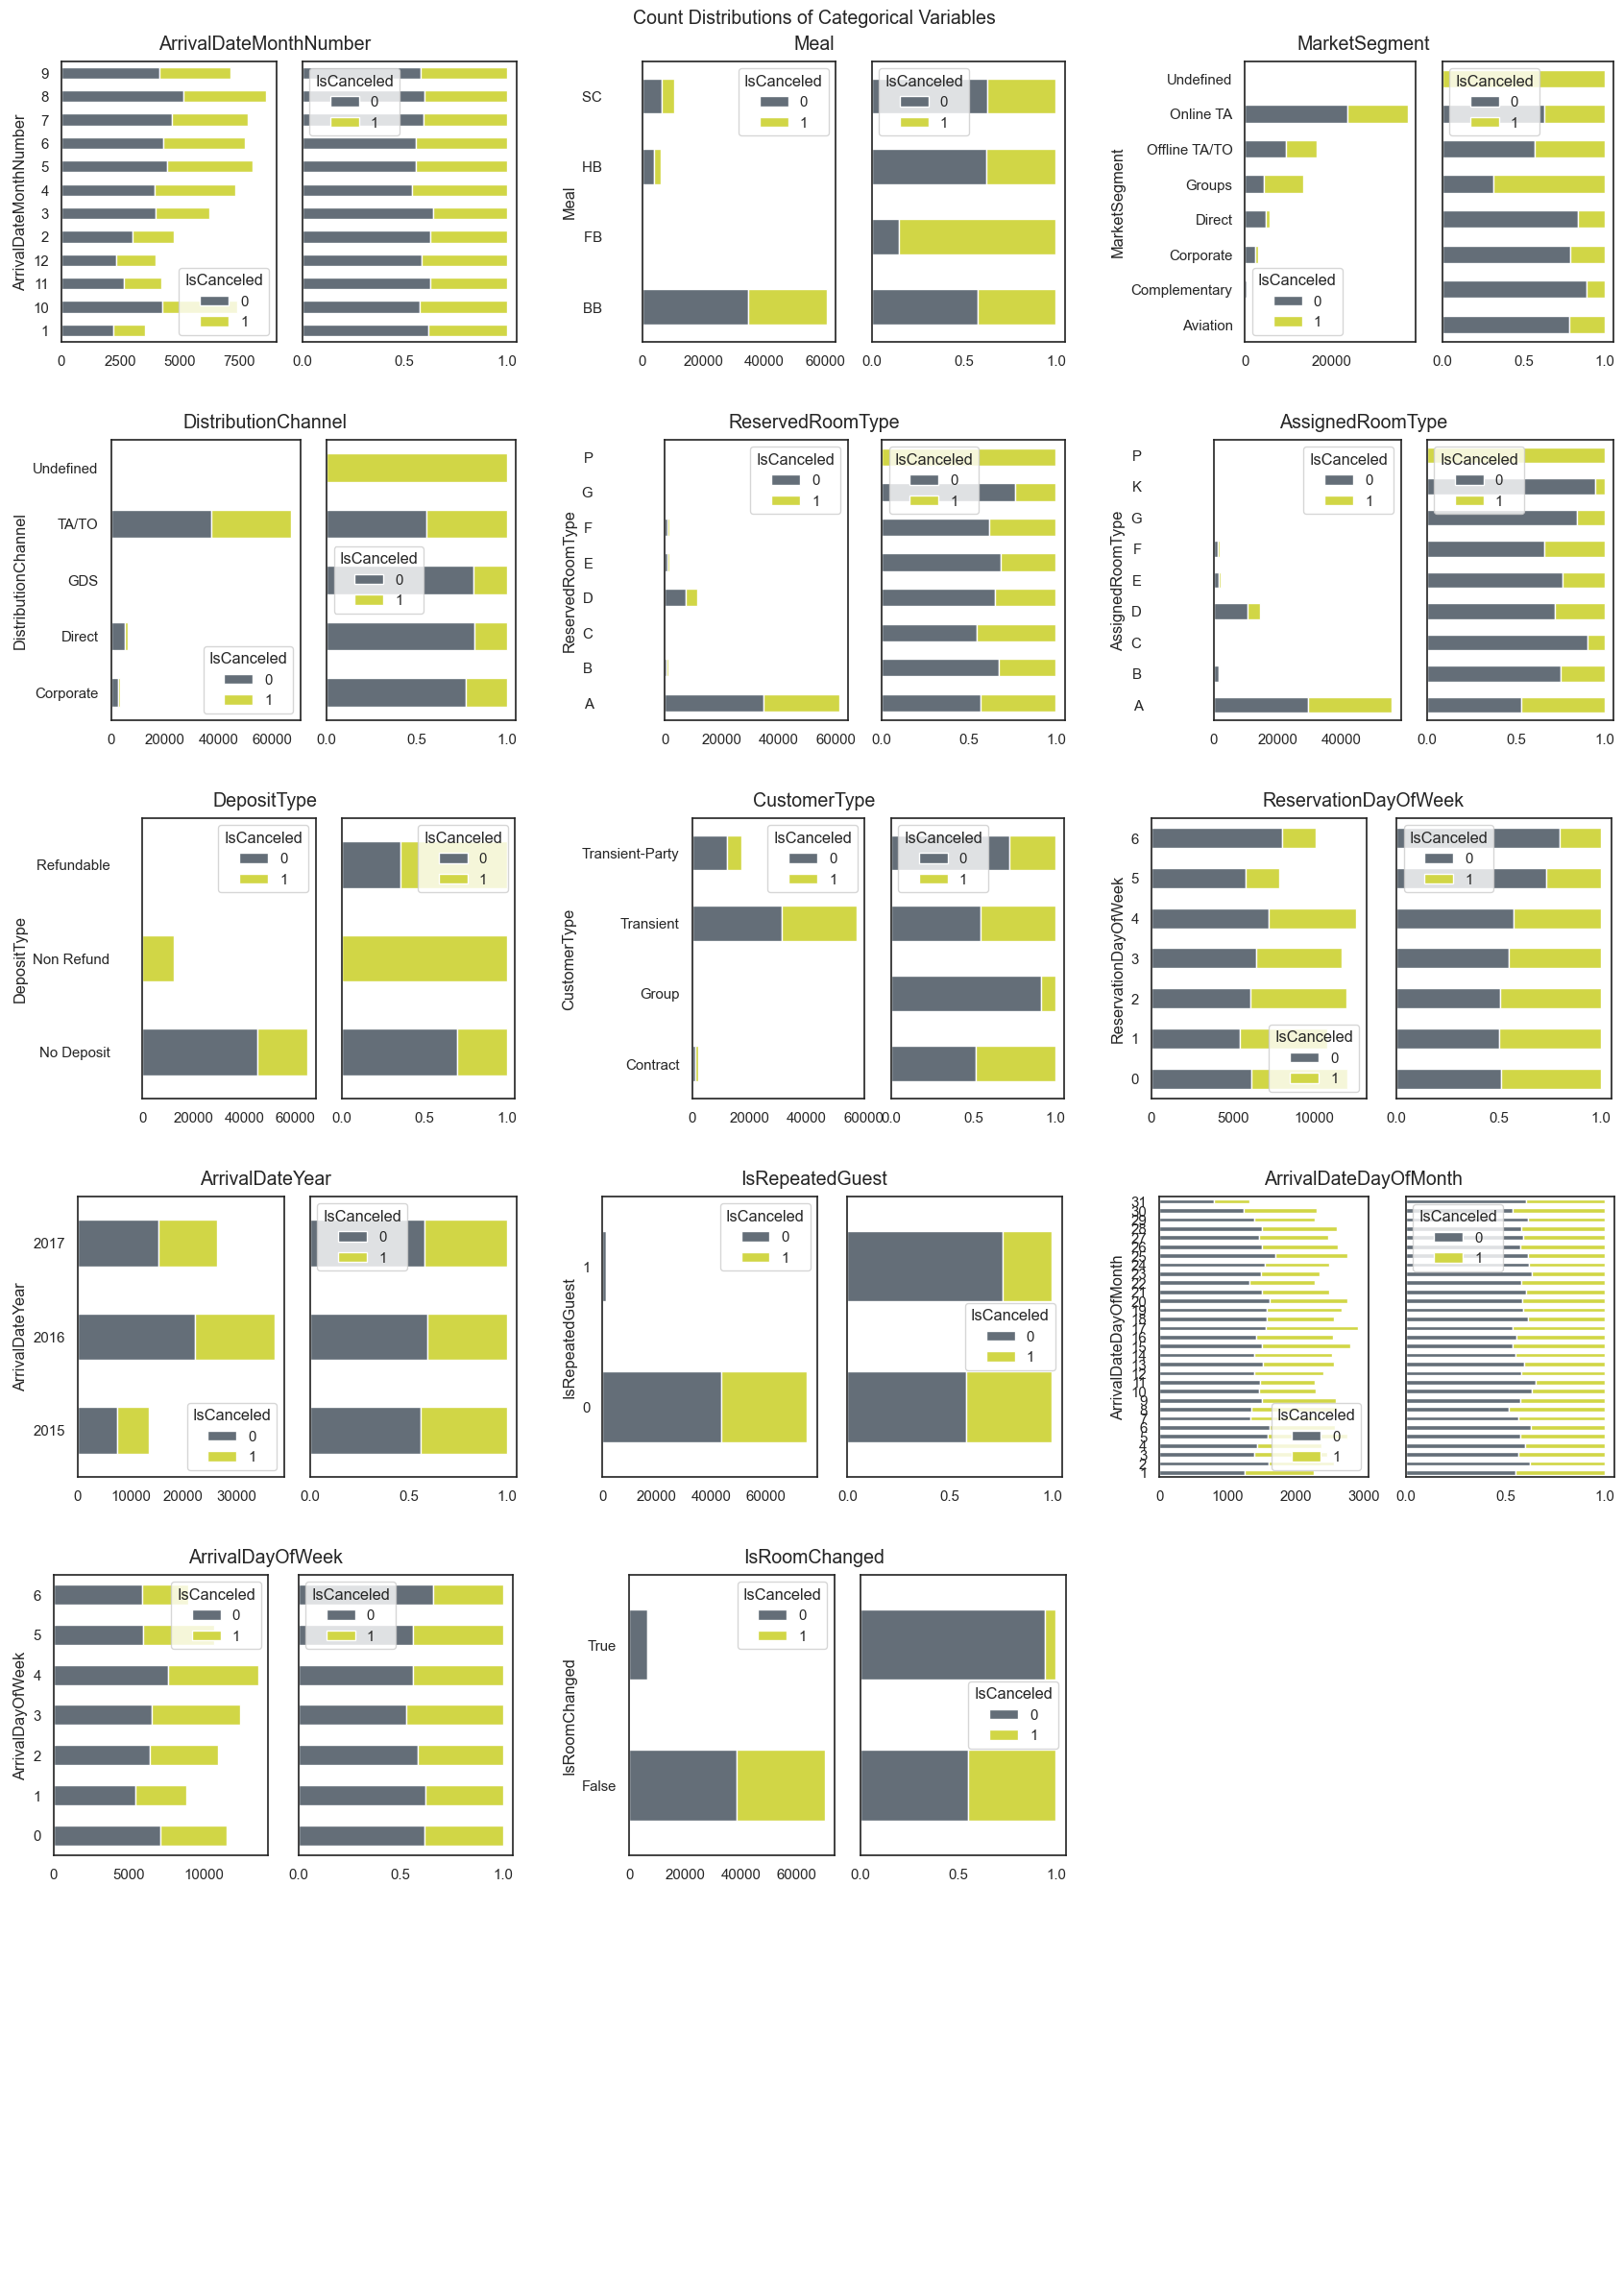

In [232]:
#TODO
# SHOULD WE DELETE SOME CATEGORICAL OUTLIERS?
plot_cat_counts(data_out_rem, to_plot)

In [233]:
data_out_rem.drop("Outliers", axis = 1, inplace = True)
df = data_out_rem.copy()

## SCALING

In [234]:
data_scal = df.copy()

In [235]:
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[metric_features])
scaled_feat

array([[0.01129944, 0.5       , 0.        , ..., 0.        , 0.03508772,
        0.        ],
       [0.16572505, 0.5       , 0.        , ..., 0.2       , 0.07017544,
        0.22794994],
       [0.12241055, 0.5       , 0.        , ..., 0.2       , 0.07017544,
        0.20262217],
       ...,
       [0.0433145 , 0.65384615, 0.125     , ..., 0.        , 0.12280702,
        0.50132598],
       [0.06403013, 0.65384615, 0.125     , ..., 0.8       , 0.12280702,
        0.82238528],
       [0.20527307, 0.65384615, 0.125     , ..., 0.        , 0.12280702,
        0.54439809]])

In [236]:
data_scal[metric_features] = scaled_feat
data_scal.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,0.011299,2015,0.5,1,0.000,0.048780,0.25,0.0,0.0,HB,PRT,Offline TA/TO,TA/TO,0,0.0,0.0,A,A,0.0,No Deposit,6,NULL,0.0,Transient,0.000000,0.0,0.0,Check-Out,2015-07-03,0.035088,0.000000,7,2015-07-01,2,3,27,7,4,False
1,1,0.165725,2015,0.5,1,0.000,0.097561,0.50,0.0,0.0,BB,PRT,Online TA,TA/TO,0,0.0,0.0,A,A,0.0,No Deposit,9,NULL,0.0,Transient,0.273214,0.0,0.2,Canceled,2015-07-01,0.070175,0.227950,7,2015-07-01,2,1,27,7,2,False
2,1,0.122411,2015,0.5,1,0.000,0.097561,0.25,0.0,0.0,BB,PRT,Online TA,TA/TO,0,0.0,0.0,A,A,0.0,No Deposit,9,NULL,0.0,Transient,0.242857,0.0,0.2,Canceled,2015-04-30,0.070175,0.202622,7,2015-07-01,2,30,18,4,3,False
3,1,0.173258,2015,0.5,1,0.125,0.097561,0.50,0.0,0.0,BB,PRT,Online TA,TA/TO,0,0.0,0.0,A,A,0.0,No Deposit,9,NULL,0.0,Transient,0.273214,0.0,0.4,Canceled,2015-06-23,0.105263,0.341925,7,2015-07-01,2,23,26,6,1,False
4,1,0.188324,2015,0.5,2,0.000,0.048780,0.50,0.0,0.0,BB,PRT,Online TA,TA/TO,0,0.0,0.0,A,A,0.0,No Deposit,9,NULL,0.0,Transient,0.273214,0.0,0.2,Canceled,2015-04-02,0.035088,0.113975,7,2015-07-02,3,2,14,4,3,False


In [237]:
df = data_scal.copy()

## ENCODING

In [238]:
data_ohc = df.copy()

In [239]:
categorical_features

['Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDateMonthNumber',
 'ArrivalDate',
 'ArrivalDayOfWeek',
 'ReservationDayOfMonth',
 'ReservationWeekOfYear',
 'ReservationMonth',
 'ReservationDayOfWeek',
 'IsRoomChanged',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'IsRepeatedGuest',
 'IsCanceled']

In [240]:
#TODO discuss it --> is it worthy ? some models do not need it (ex DT)
#List of features to be encoded using one hot encoder
to_encode = ['Meal', 'MarketSegment', 'DistributionChannel', 'DepositType', 'CustomerType']

In [241]:
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df[to_encode])
ohc_feat_names = ohc.get_feature_names(input_features=to_encode)
ohc_df = pd.DataFrame(ohc_feat, index=df.index, columns=ohc_feat_names)

ohc_df

,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Undefined,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79327,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [242]:
df_ohc = pd.concat([data_ohc.drop(columns=categorical_features), ohc_df], axis=1)
df_ohc

,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Undefined,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,0.011299,0.500000,0.000,0.048780,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.035088,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.165725,0.500000,0.000,0.097561,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.273214,0.0,0.2,0.070175,0.227950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.122411,0.500000,0.000,0.097561,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.242857,0.0,0.2,0.070175,0.202622,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.173258,0.500000,0.125,0.097561,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.273214,0.0,0.4,0.105263,0.341925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.188324,0.500000,0.000,0.048780,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.273214,0.0,0.2,0.035088,0.113975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79323,0.308851,0.653846,0.125,0.097561,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.312857,0.0,0.0,0.105263,0.391538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79324,0.039548,0.653846,0.125,0.121951,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.343357,0.0,0.4,0.122807,0.501326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79325,0.043315,0.653846,0.125,0.121951,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.343357,0.0,0.0,0.122807,0.501326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79327,0.064030,0.653846,0.125,0.121951,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.563250,0.0,0.8,0.122807,0.822385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [243]:
#TO AVOID ENCODING COMMENT THIS WHOLE CELL

#Adding encoded features to metric and removing from categorical
for feat in to_encode:
    categorical_features.remove(feat)

encoded_feat = []

for feat in ohc_df.columns:
    feat = feat.replace(" ", "")
    encoded_feat.append(feat)

metric_features.extend(encoded_feat)

df = df_ohc.copy()

In [244]:
metric_features

['LeadTime',
 'ArrivalDateWeekNumber',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'DurationOfStay',
 'TotalValue',
 'Meal_BB',
 'Meal_FB',
 'Meal_HB',
 'Meal_SC',
 'MarketSegment_Aviation',
 'MarketSegment_Complementary',
 'MarketSegment_Corporate',
 'MarketSegment_Direct',
 'MarketSegment_Groups',
 'MarketSegment_OfflineTA/TO',
 'MarketSegment_OnlineTA',
 'MarketSegment_Undefined',
 'DistributionChannel_Corporate',
 'DistributionChannel_Direct',
 'DistributionChannel_GDS',
 'DistributionChannel_TA/TO',
 'DistributionChannel_Undefined',
 'DepositType_NoDeposit',
 'DepositType_NonRefund',
 'DepositType_Refundable',
 'CustomerType_Contract',
 'CustomerType_Group',
 'CustomerType_Transient',
 'CustomerType_Transient-Party']

In [245]:
categorical_features

['Country',
 'ReservedRoomType',
 'AssignedRoomType',
 'Agent',
 'Company',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDateMonthNumber',
 'ArrivalDate',
 'ArrivalDayOfWeek',
 'ReservationDayOfMonth',
 'ReservationWeekOfYear',
 'ReservationMonth',
 'ReservationDayOfWeek',
 'IsRoomChanged',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'IsRepeatedGuest',
 'IsCanceled']